In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
import tensorflow
import cv2
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
path_to_train = '/Users/carol/Desktop/Kaggle/input/train/'
data = pd.read_csv('/Users/carol/Desktop/Kaggle/input/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [3]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
            
    
    def load_image(path, shape):
        image_red_ch = skimage.io.imread(path+'_red.png')/255.0
        image_yellow_ch = skimage.io.imread(path+'_yellow.png')/255.0
        image_green_ch = skimage.io.imread(path+'_green.png')/255.0
        image_blue_ch = skimage.io.imread(path+'_blue.png')/255.0

        image_red_ch += (image_yellow_ch/2).astype(np.uint8) 
        image_green_ch += (image_yellow_ch/2).astype(np.uint8)

        image = np.stack((
            image_red_ch, 
            image_green_ch, 
            image_blue_ch), -1)
        image = resize(image, (shape[0], shape[1]), mode='reflect')
        return image
                
            
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug

In [4]:
input_shape = (384,384,3)

# create train datagen
train_datagen = data_generator.create_train(
    train_dataset_info, 5, input_shape, augument=True)

min: 0.0, max: 1.0


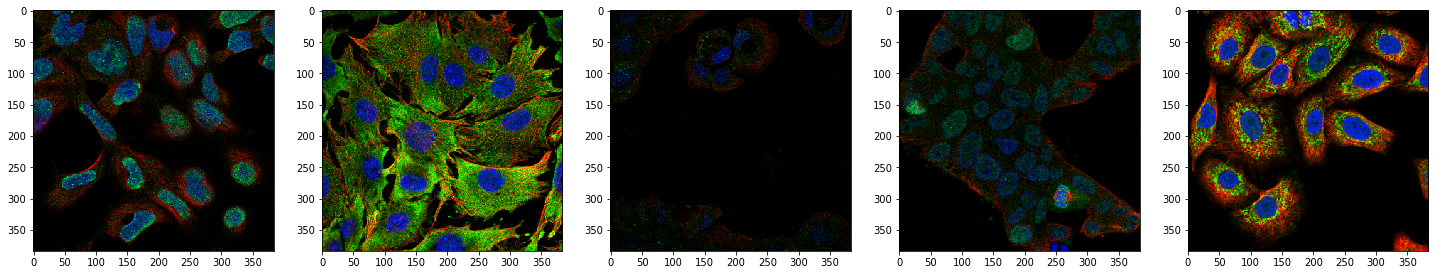

In [5]:
images, labels = next(train_datagen)

fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])
print('min: {0}, max: {1}'.format(images.min(), images.max()))

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras

def create_model(input_shape, n_out):
    inp = Input(input_shape)
    pretrain_model = InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=inp)
    x = pretrain_model.output
    x = GlobalAveragePooling2D()(x)
    #x = Flatten()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(n_out)(x)
    x = Activation('sigmoid')(x)
    
    for layer in pretrain_model.layers:
        layer.trainable = True
        
    return Model(inp, x)

Using TensorFlow backend.


In [7]:
keras.backend.clear_session()

model = create_model(input_shape=input_shape, n_out=28)
model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-04), metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 191, 191, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 191, 191, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 191, 191, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [10]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

epochs = 4; batch_size = 32
checkpointer = ModelCheckpoint('/Users/carol/Desktop/Kaggle/input/InceptionResNetV2.model', verbose=2, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1)

# split and suffle data 
np.random.seed(2018)
indexes = np.arange(train_dataset_info.shape[0])
np.random.shuffle(indexes)
train_indexes = indexes[:27500]
valid_indexes = indexes[27500:]

# create train and valid datagens
train_generator = data_generator.create_train(train_dataset_info[train_indexes], batch_size, input_shape, augument=True)
validation_generator = data_generator.create_train(train_dataset_info[valid_indexes], 100, input_shape, augument=False)

# train model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    validation_data=next(validation_generator),
    epochs=epochs, 
    verbose=1)

Epoch 1/1
1/1 [==============================] - 154s 154s/step - loss: 4.0643 - acc: 0.4062 - val_loss: 4.1026 - val_acc: 0.4200


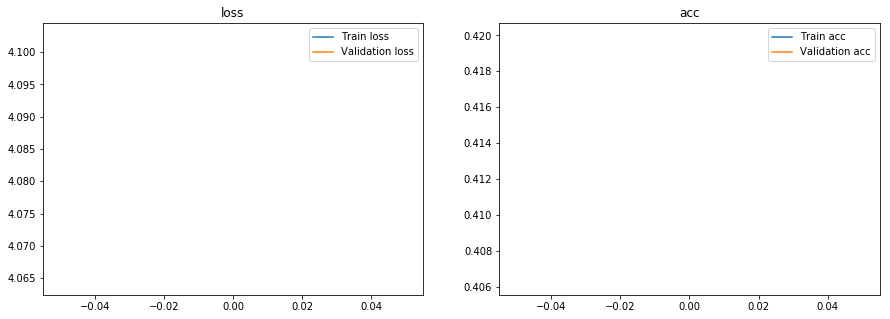

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
ax[0].legend()
ax[1].legend()

In [13]:
submit = pd.read_csv('/Users/carol/Desktop/Kaggle/input/sample_submission.csv')

In [17]:
%%time
predicted = []
for name in tqdm(submit['Id']):
    path = os.path.join('/Users/carol/Desktop/Kaggle/input/test/', name)
    image = data_generator.load_image(path, (384,384,3))
    score_predict = model.predict(image[np.newaxis])[0]
    label_predict = np.arange(28)[score_predict>=0.5]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)



  0%|          | 0/11702 [00:00<?, ?it/s]

  0%|          | 1/11702 [00:00<2:18:30,  1.41it/s]

  0%|          | 2/11702 [00:01<2:13:43,  1.46it/s]

  0%|          | 3/11702 [00:02<2:12:02,  1.48it/s]

  0%|          | 4/11702 [00:02<2:11:23,  1.48it/s]

  0%|          | 5/11702 [00:03<2:09:58,  1.50it/s]

  0%|          | 6/11702 [00:03<2:09:09,  1.51it/s]

  0%|          | 7/11702 [00:04<2:08:48,  1.51it/s]

  0%|          | 8/11702 [00:05<2:09:34,  1.50it/s]

  0%|          | 9/11702 [00:06<2:10:02,  1.50it/s]

  0%|          | 10/11702 [00:06<2:10:13,  1.50it/s]

  0%|          | 11/11702 [00:07<2:09:54,  1.50it/s]

  0%|          | 12/11702 [00:07<2:09:38,  1.50it/s]

  0%|          | 13/11702 [00:08<2:09:24,  1.51it/s]

  0%|          | 14/11702 [00:09<2:09:34,  1.50it/s]

  0%|          | 15/11702 [00:09<2:09:32,  1.50it/s]

  0%|          | 16/11702 [00:10<2:09:24,  1.51it/s]

  0%|          | 17/11702 [00:11<2:10:15,  1.50it/s]

  0%|          | 18/11702 [00:12<2:10:12,  1.5

  1%|          | 136/11702 [01:34<2:14:13,  1.44it/s]

  1%|          | 137/11702 [01:35<2:14:14,  1.44it/s]

  1%|          | 138/11702 [01:36<2:14:12,  1.44it/s]

  1%|          | 139/11702 [01:36<2:14:10,  1.44it/s]

  1%|          | 140/11702 [01:37<2:14:08,  1.44it/s]

  1%|          | 141/11702 [01:38<2:14:06,  1.44it/s]

  1%|          | 142/11702 [01:38<2:14:07,  1.44it/s]

  1%|          | 143/11702 [01:39<2:14:05,  1.44it/s]

  1%|          | 144/11702 [01:40<2:14:04,  1.44it/s]

  1%|          | 145/11702 [01:40<2:14:02,  1.44it/s]

  1%|          | 146/11702 [01:41<2:14:01,  1.44it/s]

  1%|▏         | 147/11702 [01:42<2:13:59,  1.44it/s]

  1%|▏         | 148/11702 [01:42<2:14:00,  1.44it/s]

  1%|▏         | 149/11702 [01:43<2:13:59,  1.44it/s]

  1%|▏         | 150/11702 [01:44<2:14:01,  1.44it/s]

  1%|▏         | 151/11702 [01:45<2:14:00,  1.44it/s]

  1%|▏         | 152/11702 [01:45<2:13:59,  1.44it/s]

  1%|▏         | 153/11702 [01:46<2:13:58,  1.44it/s]

  1%|▏    

  2%|▏         | 270/11702 [03:07<2:12:39,  1.44it/s]

  2%|▏         | 271/11702 [03:08<2:12:38,  1.44it/s]

  2%|▏         | 272/11702 [03:09<2:12:38,  1.44it/s]

  2%|▏         | 273/11702 [03:10<2:12:37,  1.44it/s]

  2%|▏         | 274/11702 [03:10<2:12:35,  1.44it/s]

  2%|▏         | 275/11702 [03:11<2:12:34,  1.44it/s]

  2%|▏         | 276/11702 [03:12<2:12:33,  1.44it/s]

  2%|▏         | 277/11702 [03:12<2:12:33,  1.44it/s]

  2%|▏         | 278/11702 [03:13<2:12:32,  1.44it/s]

  2%|▏         | 279/11702 [03:14<2:12:31,  1.44it/s]

  2%|▏         | 280/11702 [03:14<2:12:30,  1.44it/s]

  2%|▏         | 281/11702 [03:15<2:12:29,  1.44it/s]

  2%|▏         | 282/11702 [03:16<2:12:29,  1.44it/s]

  2%|▏         | 283/11702 [03:17<2:12:29,  1.44it/s]

  2%|▏         | 284/11702 [03:17<2:12:30,  1.44it/s]

  2%|▏         | 285/11702 [03:18<2:12:31,  1.44it/s]

  2%|▏         | 286/11702 [03:19<2:12:31,  1.44it/s]

  2%|▏         | 287/11702 [03:19<2:12:30,  1.44it/s]

  2%|▏    

  3%|▎         | 404/11702 [04:43<2:12:08,  1.43it/s]

  3%|▎         | 405/11702 [04:44<2:12:07,  1.43it/s]

  3%|▎         | 406/11702 [04:44<2:12:06,  1.43it/s]

  3%|▎         | 407/11702 [04:45<2:12:05,  1.43it/s]

  3%|▎         | 408/11702 [04:46<2:12:04,  1.43it/s]

  3%|▎         | 409/11702 [04:46<2:12:03,  1.43it/s]

  4%|▎         | 410/11702 [04:47<2:12:02,  1.43it/s]

  4%|▎         | 411/11702 [04:48<2:12:02,  1.43it/s]

  4%|▎         | 412/11702 [04:49<2:12:01,  1.43it/s]

  4%|▎         | 413/11702 [04:49<2:12:00,  1.43it/s]

  4%|▎         | 414/11702 [04:50<2:12:00,  1.43it/s]

  4%|▎         | 415/11702 [04:51<2:11:59,  1.43it/s]

  4%|▎         | 416/11702 [04:51<2:11:59,  1.43it/s]

  4%|▎         | 417/11702 [04:52<2:11:57,  1.43it/s]

  4%|▎         | 418/11702 [04:53<2:11:56,  1.43it/s]

  4%|▎         | 419/11702 [04:53<2:11:56,  1.43it/s]

  4%|▎         | 420/11702 [04:54<2:11:55,  1.43it/s]

  4%|▎         | 421/11702 [04:55<2:11:54,  1.43it/s]

  4%|▎    

  5%|▍         | 538/11702 [06:16<2:10:17,  1.43it/s]

  5%|▍         | 539/11702 [06:17<2:10:16,  1.43it/s]

  5%|▍         | 540/11702 [06:18<2:10:15,  1.43it/s]

  5%|▍         | 541/11702 [06:18<2:10:15,  1.43it/s]

  5%|▍         | 542/11702 [06:19<2:10:14,  1.43it/s]

  5%|▍         | 543/11702 [06:20<2:10:16,  1.43it/s]

  5%|▍         | 544/11702 [06:21<2:10:18,  1.43it/s]

  5%|▍         | 545/11702 [06:22<2:10:23,  1.43it/s]

  5%|▍         | 546/11702 [06:23<2:10:31,  1.42it/s]

  5%|▍         | 547/11702 [06:24<2:10:33,  1.42it/s]

  5%|▍         | 548/11702 [06:24<2:10:33,  1.42it/s]

  5%|▍         | 549/11702 [06:25<2:10:33,  1.42it/s]

  5%|▍         | 550/11702 [06:26<2:10:32,  1.42it/s]

  5%|▍         | 551/11702 [06:27<2:10:32,  1.42it/s]

  5%|▍         | 552/11702 [06:27<2:10:32,  1.42it/s]

  5%|▍         | 553/11702 [06:28<2:10:31,  1.42it/s]

  5%|▍         | 554/11702 [06:29<2:10:32,  1.42it/s]

  5%|▍         | 555/11702 [06:30<2:10:33,  1.42it/s]

  5%|▍    

  6%|▌         | 672/11702 [07:50<2:08:42,  1.43it/s]

  6%|▌         | 673/11702 [07:51<2:08:42,  1.43it/s]

  6%|▌         | 674/11702 [07:51<2:08:41,  1.43it/s]

  6%|▌         | 675/11702 [07:52<2:08:40,  1.43it/s]

  6%|▌         | 676/11702 [07:53<2:08:39,  1.43it/s]

  6%|▌         | 677/11702 [07:53<2:08:38,  1.43it/s]

  6%|▌         | 678/11702 [07:54<2:08:37,  1.43it/s]

  6%|▌         | 679/11702 [07:55<2:08:37,  1.43it/s]

  6%|▌         | 680/11702 [07:56<2:08:36,  1.43it/s]

  6%|▌         | 681/11702 [07:56<2:08:35,  1.43it/s]

  6%|▌         | 682/11702 [07:57<2:08:34,  1.43it/s]

  6%|▌         | 683/11702 [07:58<2:08:34,  1.43it/s]

  6%|▌         | 684/11702 [07:58<2:08:33,  1.43it/s]

  6%|▌         | 685/11702 [07:59<2:08:32,  1.43it/s]

  6%|▌         | 686/11702 [08:00<2:08:31,  1.43it/s]

  6%|▌         | 687/11702 [08:00<2:08:30,  1.43it/s]

  6%|▌         | 688/11702 [08:01<2:08:29,  1.43it/s]

  6%|▌         | 689/11702 [08:02<2:08:27,  1.43it/s]

  6%|▌    

  7%|▋         | 806/11702 [09:26<2:07:36,  1.42it/s]

  7%|▋         | 807/11702 [09:27<2:07:35,  1.42it/s]

  7%|▋         | 808/11702 [09:27<2:07:34,  1.42it/s]

  7%|▋         | 809/11702 [09:28<2:07:33,  1.42it/s]

  7%|▋         | 810/11702 [09:29<2:07:32,  1.42it/s]

  7%|▋         | 811/11702 [09:29<2:07:32,  1.42it/s]

  7%|▋         | 812/11702 [09:30<2:07:30,  1.42it/s]

  7%|▋         | 813/11702 [09:31<2:07:29,  1.42it/s]

  7%|▋         | 814/11702 [09:31<2:07:29,  1.42it/s]

  7%|▋         | 815/11702 [09:32<2:07:27,  1.42it/s]

  7%|▋         | 816/11702 [09:33<2:07:26,  1.42it/s]

  7%|▋         | 817/11702 [09:33<2:07:25,  1.42it/s]

  7%|▋         | 818/11702 [09:34<2:07:24,  1.42it/s]

  7%|▋         | 819/11702 [09:35<2:07:23,  1.42it/s]

  7%|▋         | 820/11702 [09:35<2:07:22,  1.42it/s]

  7%|▋         | 821/11702 [09:36<2:07:21,  1.42it/s]

  7%|▋         | 822/11702 [09:37<2:07:20,  1.42it/s]

  7%|▋         | 823/11702 [09:37<2:07:20,  1.42it/s]

  7%|▋    

  8%|▊         | 940/11702 [11:02<2:06:29,  1.42it/s]

  8%|▊         | 941/11702 [11:03<2:06:28,  1.42it/s]

  8%|▊         | 942/11702 [11:04<2:06:27,  1.42it/s]

  8%|▊         | 943/11702 [11:04<2:06:26,  1.42it/s]

  8%|▊         | 944/11702 [11:05<2:06:25,  1.42it/s]

  8%|▊         | 945/11702 [11:06<2:06:25,  1.42it/s]

  8%|▊         | 946/11702 [11:07<2:06:24,  1.42it/s]

  8%|▊         | 947/11702 [11:07<2:06:23,  1.42it/s]

  8%|▊         | 948/11702 [11:08<2:06:21,  1.42it/s]

  8%|▊         | 949/11702 [11:09<2:06:21,  1.42it/s]

  8%|▊         | 950/11702 [11:09<2:06:20,  1.42it/s]

  8%|▊         | 951/11702 [11:10<2:06:19,  1.42it/s]

  8%|▊         | 952/11702 [11:11<2:06:18,  1.42it/s]

  8%|▊         | 953/11702 [11:11<2:06:17,  1.42it/s]

  8%|▊         | 954/11702 [11:12<2:06:16,  1.42it/s]

  8%|▊         | 955/11702 [11:13<2:06:15,  1.42it/s]

  8%|▊         | 956/11702 [11:13<2:06:14,  1.42it/s]

  8%|▊         | 957/11702 [11:14<2:06:14,  1.42it/s]

  8%|▊    

  9%|▉         | 1073/11702 [12:36<2:04:55,  1.42it/s]

  9%|▉         | 1074/11702 [12:37<2:04:53,  1.42it/s]

  9%|▉         | 1075/11702 [12:37<2:04:52,  1.42it/s]

  9%|▉         | 1076/11702 [12:38<2:04:51,  1.42it/s]

  9%|▉         | 1077/11702 [12:39<2:04:50,  1.42it/s]

  9%|▉         | 1078/11702 [12:40<2:04:50,  1.42it/s]

  9%|▉         | 1079/11702 [12:40<2:04:49,  1.42it/s]

  9%|▉         | 1080/11702 [12:41<2:04:49,  1.42it/s]

  9%|▉         | 1081/11702 [12:42<2:04:48,  1.42it/s]

  9%|▉         | 1082/11702 [12:42<2:04:48,  1.42it/s]

  9%|▉         | 1083/11702 [12:43<2:04:48,  1.42it/s]

  9%|▉         | 1084/11702 [12:44<2:04:49,  1.42it/s]

  9%|▉         | 1085/11702 [12:45<2:04:48,  1.42it/s]

  9%|▉         | 1086/11702 [12:46<2:04:48,  1.42it/s]

  9%|▉         | 1087/11702 [12:46<2:04:47,  1.42it/s]

  9%|▉         | 1088/11702 [12:47<2:04:47,  1.42it/s]

  9%|▉         | 1089/11702 [12:48<2:04:46,  1.42it/s]

  9%|▉         | 1090/11702 [12:48<2:04:45,  1.4

 10%|█         | 1205/11702 [14:11<2:03:35,  1.42it/s]

 10%|█         | 1206/11702 [14:12<2:03:35,  1.42it/s]

 10%|█         | 1207/11702 [14:12<2:03:35,  1.42it/s]

 10%|█         | 1208/11702 [14:13<2:03:34,  1.42it/s]

 10%|█         | 1209/11702 [14:14<2:03:34,  1.42it/s]

 10%|█         | 1210/11702 [14:14<2:03:33,  1.42it/s]

 10%|█         | 1211/11702 [14:15<2:03:33,  1.42it/s]

 10%|█         | 1212/11702 [14:16<2:03:32,  1.42it/s]

 10%|█         | 1213/11702 [14:17<2:03:32,  1.42it/s]

 10%|█         | 1214/11702 [14:17<2:03:31,  1.42it/s]

 10%|█         | 1215/11702 [14:18<2:03:31,  1.42it/s]

 10%|█         | 1216/11702 [14:19<2:03:30,  1.41it/s]

 10%|█         | 1217/11702 [14:20<2:03:30,  1.41it/s]

 10%|█         | 1218/11702 [14:20<2:03:29,  1.42it/s]

 10%|█         | 1219/11702 [14:21<2:03:28,  1.42it/s]

 10%|█         | 1220/11702 [14:22<2:03:27,  1.42it/s]

 10%|█         | 1221/11702 [14:22<2:03:26,  1.42it/s]

 10%|█         | 1222/11702 [14:23<2:03:25,  1.4

 11%|█▏        | 1337/11702 [15:45<2:02:11,  1.41it/s]

 11%|█▏        | 1338/11702 [15:46<2:02:10,  1.41it/s]

 11%|█▏        | 1339/11702 [15:47<2:02:10,  1.41it/s]

 11%|█▏        | 1340/11702 [15:47<2:02:09,  1.41it/s]

 11%|█▏        | 1341/11702 [15:48<2:02:08,  1.41it/s]

 11%|█▏        | 1342/11702 [15:49<2:02:08,  1.41it/s]

 11%|█▏        | 1343/11702 [15:49<2:02:07,  1.41it/s]

 11%|█▏        | 1344/11702 [15:50<2:02:06,  1.41it/s]

 11%|█▏        | 1345/11702 [15:51<2:02:06,  1.41it/s]

 12%|█▏        | 1346/11702 [15:52<2:02:05,  1.41it/s]

 12%|█▏        | 1347/11702 [15:52<2:02:04,  1.41it/s]

 12%|█▏        | 1348/11702 [15:53<2:02:04,  1.41it/s]

 12%|█▏        | 1349/11702 [15:54<2:02:03,  1.41it/s]

 12%|█▏        | 1350/11702 [15:54<2:02:02,  1.41it/s]

 12%|█▏        | 1351/11702 [15:55<2:02:01,  1.41it/s]

 12%|█▏        | 1352/11702 [15:56<2:02:00,  1.41it/s]

 12%|█▏        | 1353/11702 [15:56<2:01:59,  1.41it/s]

 12%|█▏        | 1354/11702 [15:57<2:01:59,  1.4

 13%|█▎        | 1469/11702 [17:22<2:01:03,  1.41it/s]

 13%|█▎        | 1470/11702 [17:23<2:01:03,  1.41it/s]

 13%|█▎        | 1471/11702 [17:24<2:01:02,  1.41it/s]

 13%|█▎        | 1472/11702 [17:24<2:01:01,  1.41it/s]

 13%|█▎        | 1473/11702 [17:25<2:01:00,  1.41it/s]

 13%|█▎        | 1474/11702 [17:26<2:01:00,  1.41it/s]

 13%|█▎        | 1475/11702 [17:27<2:00:59,  1.41it/s]

 13%|█▎        | 1476/11702 [17:27<2:00:58,  1.41it/s]

 13%|█▎        | 1477/11702 [17:28<2:00:58,  1.41it/s]

 13%|█▎        | 1478/11702 [17:29<2:00:57,  1.41it/s]

 13%|█▎        | 1479/11702 [17:29<2:00:56,  1.41it/s]

 13%|█▎        | 1480/11702 [17:30<2:00:56,  1.41it/s]

 13%|█▎        | 1481/11702 [17:31<2:00:55,  1.41it/s]

 13%|█▎        | 1482/11702 [17:32<2:00:55,  1.41it/s]

 13%|█▎        | 1483/11702 [17:32<2:00:55,  1.41it/s]

 13%|█▎        | 1484/11702 [17:33<2:00:54,  1.41it/s]

 13%|█▎        | 1485/11702 [17:34<2:00:54,  1.41it/s]

 13%|█▎        | 1486/11702 [17:35<2:00:53,  1.4

 14%|█▎        | 1601/11702 [18:56<1:59:31,  1.41it/s]

 14%|█▎        | 1602/11702 [18:57<1:59:30,  1.41it/s]

 14%|█▎        | 1603/11702 [18:58<1:59:30,  1.41it/s]

 14%|█▎        | 1604/11702 [18:58<1:59:29,  1.41it/s]

 14%|█▎        | 1605/11702 [18:59<1:59:28,  1.41it/s]

 14%|█▎        | 1606/11702 [19:00<1:59:28,  1.41it/s]

 14%|█▎        | 1607/11702 [19:01<1:59:27,  1.41it/s]

 14%|█▎        | 1608/11702 [19:01<1:59:27,  1.41it/s]

 14%|█▎        | 1609/11702 [19:02<1:59:26,  1.41it/s]

 14%|█▍        | 1610/11702 [19:03<1:59:25,  1.41it/s]

 14%|█▍        | 1611/11702 [19:03<1:59:24,  1.41it/s]

 14%|█▍        | 1612/11702 [19:04<1:59:23,  1.41it/s]

 14%|█▍        | 1613/11702 [19:05<1:59:23,  1.41it/s]

 14%|█▍        | 1614/11702 [19:05<1:59:22,  1.41it/s]

 14%|█▍        | 1615/11702 [19:06<1:59:22,  1.41it/s]

 14%|█▍        | 1616/11702 [19:07<1:59:21,  1.41it/s]

 14%|█▍        | 1617/11702 [19:08<1:59:20,  1.41it/s]

 14%|█▍        | 1618/11702 [19:08<1:59:20,  1.4

 15%|█▍        | 1733/11702 [20:30<1:57:59,  1.41it/s]

 15%|█▍        | 1734/11702 [20:31<1:57:58,  1.41it/s]

 15%|█▍        | 1735/11702 [20:32<1:57:58,  1.41it/s]

 15%|█▍        | 1736/11702 [20:32<1:57:57,  1.41it/s]

 15%|█▍        | 1737/11702 [20:33<1:57:56,  1.41it/s]

 15%|█▍        | 1738/11702 [20:34<1:57:55,  1.41it/s]

 15%|█▍        | 1739/11702 [20:34<1:57:55,  1.41it/s]

 15%|█▍        | 1740/11702 [20:35<1:57:54,  1.41it/s]

 15%|█▍        | 1741/11702 [20:36<1:57:53,  1.41it/s]

 15%|█▍        | 1742/11702 [20:37<1:57:53,  1.41it/s]

 15%|█▍        | 1743/11702 [20:37<1:57:52,  1.41it/s]

 15%|█▍        | 1744/11702 [20:38<1:57:51,  1.41it/s]

 15%|█▍        | 1745/11702 [20:39<1:57:51,  1.41it/s]

 15%|█▍        | 1746/11702 [20:39<1:57:50,  1.41it/s]

 15%|█▍        | 1747/11702 [20:40<1:57:49,  1.41it/s]

 15%|█▍        | 1748/11702 [20:41<1:57:48,  1.41it/s]

 15%|█▍        | 1749/11702 [20:42<1:57:48,  1.41it/s]

 15%|█▍        | 1750/11702 [20:42<1:57:47,  1.4

 16%|█▌        | 1865/11702 [22:03<1:56:19,  1.41it/s]

 16%|█▌        | 1866/11702 [22:03<1:56:18,  1.41it/s]

 16%|█▌        | 1867/11702 [22:04<1:56:17,  1.41it/s]

 16%|█▌        | 1868/11702 [22:05<1:56:16,  1.41it/s]

 16%|█▌        | 1869/11702 [22:05<1:56:15,  1.41it/s]

 16%|█▌        | 1870/11702 [22:06<1:56:15,  1.41it/s]

 16%|█▌        | 1871/11702 [22:07<1:56:14,  1.41it/s]

 16%|█▌        | 1872/11702 [22:08<1:56:14,  1.41it/s]

 16%|█▌        | 1873/11702 [22:08<1:56:13,  1.41it/s]

 16%|█▌        | 1874/11702 [22:09<1:56:12,  1.41it/s]

 16%|█▌        | 1875/11702 [22:10<1:56:12,  1.41it/s]

 16%|█▌        | 1876/11702 [22:10<1:56:11,  1.41it/s]

 16%|█▌        | 1877/11702 [22:11<1:56:10,  1.41it/s]

 16%|█▌        | 1878/11702 [22:12<1:56:09,  1.41it/s]

 16%|█▌        | 1879/11702 [22:12<1:56:08,  1.41it/s]

 16%|█▌        | 1880/11702 [22:13<1:56:07,  1.41it/s]

 16%|█▌        | 1881/11702 [22:14<1:56:07,  1.41it/s]

 16%|█▌        | 1882/11702 [22:15<1:56:06,  1.4

 17%|█▋        | 1997/11702 [23:35<1:54:40,  1.41it/s]

 17%|█▋        | 1998/11702 [23:36<1:54:39,  1.41it/s]

 17%|█▋        | 1999/11702 [23:37<1:54:38,  1.41it/s]

 17%|█▋        | 2000/11702 [23:37<1:54:38,  1.41it/s]

 17%|█▋        | 2001/11702 [23:38<1:54:37,  1.41it/s]

 17%|█▋        | 2002/11702 [23:39<1:54:36,  1.41it/s]

 17%|█▋        | 2003/11702 [23:39<1:54:35,  1.41it/s]

 17%|█▋        | 2004/11702 [23:40<1:54:35,  1.41it/s]

 17%|█▋        | 2005/11702 [23:41<1:54:34,  1.41it/s]

 17%|█▋        | 2006/11702 [23:42<1:54:33,  1.41it/s]

 17%|█▋        | 2007/11702 [23:42<1:54:32,  1.41it/s]

 17%|█▋        | 2008/11702 [23:43<1:54:31,  1.41it/s]

 17%|█▋        | 2009/11702 [23:44<1:54:31,  1.41it/s]

 17%|█▋        | 2010/11702 [23:44<1:54:30,  1.41it/s]

 17%|█▋        | 2011/11702 [23:45<1:54:30,  1.41it/s]

 17%|█▋        | 2012/11702 [23:46<1:54:29,  1.41it/s]

 17%|█▋        | 2013/11702 [23:47<1:54:29,  1.41it/s]

 17%|█▋        | 2014/11702 [23:47<1:54:28,  1.4

 18%|█▊        | 2129/11702 [25:08<1:53:04,  1.41it/s]

 18%|█▊        | 2130/11702 [25:09<1:53:03,  1.41it/s]

 18%|█▊        | 2131/11702 [25:10<1:53:03,  1.41it/s]

 18%|█▊        | 2132/11702 [25:10<1:53:02,  1.41it/s]

 18%|█▊        | 2133/11702 [25:11<1:53:01,  1.41it/s]

 18%|█▊        | 2134/11702 [25:12<1:53:00,  1.41it/s]

 18%|█▊        | 2135/11702 [25:12<1:52:59,  1.41it/s]

 18%|█▊        | 2136/11702 [25:13<1:52:58,  1.41it/s]

 18%|█▊        | 2137/11702 [25:14<1:52:57,  1.41it/s]

 18%|█▊        | 2138/11702 [25:14<1:52:56,  1.41it/s]

 18%|█▊        | 2139/11702 [25:15<1:52:55,  1.41it/s]

 18%|█▊        | 2140/11702 [25:16<1:52:54,  1.41it/s]

 18%|█▊        | 2141/11702 [25:16<1:52:53,  1.41it/s]

 18%|█▊        | 2142/11702 [25:17<1:52:52,  1.41it/s]

 18%|█▊        | 2143/11702 [25:18<1:52:51,  1.41it/s]

 18%|█▊        | 2144/11702 [25:18<1:52:50,  1.41it/s]

 18%|█▊        | 2145/11702 [25:19<1:52:49,  1.41it/s]

 18%|█▊        | 2146/11702 [25:20<1:52:48,  1.4

 19%|█▉        | 2261/11702 [26:41<1:51:25,  1.41it/s]

 19%|█▉        | 2262/11702 [26:41<1:51:25,  1.41it/s]

 19%|█▉        | 2263/11702 [26:42<1:51:24,  1.41it/s]

 19%|█▉        | 2264/11702 [26:43<1:51:23,  1.41it/s]

 19%|█▉        | 2265/11702 [26:44<1:51:23,  1.41it/s]

 19%|█▉        | 2266/11702 [26:44<1:51:22,  1.41it/s]

 19%|█▉        | 2267/11702 [26:45<1:51:21,  1.41it/s]

 19%|█▉        | 2268/11702 [26:46<1:51:21,  1.41it/s]

 19%|█▉        | 2269/11702 [26:46<1:51:20,  1.41it/s]

 19%|█▉        | 2270/11702 [26:47<1:51:20,  1.41it/s]

 19%|█▉        | 2271/11702 [26:48<1:51:19,  1.41it/s]

 19%|█▉        | 2272/11702 [26:49<1:51:18,  1.41it/s]

 19%|█▉        | 2273/11702 [26:49<1:51:18,  1.41it/s]

 19%|█▉        | 2274/11702 [26:50<1:51:17,  1.41it/s]

 19%|█▉        | 2275/11702 [26:51<1:51:17,  1.41it/s]

 19%|█▉        | 2276/11702 [26:52<1:51:16,  1.41it/s]

 19%|█▉        | 2277/11702 [26:52<1:51:15,  1.41it/s]

 19%|█▉        | 2278/11702 [26:53<1:51:14,  1.4

 20%|██        | 2393/11702 [28:17<1:50:02,  1.41it/s]

 20%|██        | 2394/11702 [28:17<1:50:01,  1.41it/s]

 20%|██        | 2395/11702 [28:18<1:50:01,  1.41it/s]

 20%|██        | 2396/11702 [28:19<1:50:00,  1.41it/s]

 20%|██        | 2397/11702 [28:20<1:50:00,  1.41it/s]

 20%|██        | 2398/11702 [28:20<1:49:59,  1.41it/s]

 21%|██        | 2399/11702 [28:21<1:49:58,  1.41it/s]

 21%|██        | 2400/11702 [28:22<1:49:58,  1.41it/s]

 21%|██        | 2401/11702 [28:23<1:49:57,  1.41it/s]

 21%|██        | 2402/11702 [28:23<1:49:57,  1.41it/s]

 21%|██        | 2403/11702 [28:24<1:49:56,  1.41it/s]

 21%|██        | 2404/11702 [28:25<1:49:55,  1.41it/s]

 21%|██        | 2405/11702 [28:26<1:49:55,  1.41it/s]

 21%|██        | 2406/11702 [28:26<1:49:54,  1.41it/s]

 21%|██        | 2407/11702 [28:27<1:49:53,  1.41it/s]

 21%|██        | 2408/11702 [28:28<1:49:53,  1.41it/s]

 21%|██        | 2409/11702 [28:28<1:49:52,  1.41it/s]

 21%|██        | 2410/11702 [28:29<1:49:52,  1.4

 22%|██▏       | 2525/11702 [29:51<1:48:31,  1.41it/s]

 22%|██▏       | 2526/11702 [29:52<1:48:30,  1.41it/s]

 22%|██▏       | 2527/11702 [29:53<1:48:30,  1.41it/s]

 22%|██▏       | 2528/11702 [29:53<1:48:29,  1.41it/s]

 22%|██▏       | 2529/11702 [29:54<1:48:28,  1.41it/s]

 22%|██▏       | 2530/11702 [29:55<1:48:28,  1.41it/s]

 22%|██▏       | 2531/11702 [29:55<1:48:27,  1.41it/s]

 22%|██▏       | 2532/11702 [29:56<1:48:27,  1.41it/s]

 22%|██▏       | 2533/11702 [29:57<1:48:26,  1.41it/s]

 22%|██▏       | 2534/11702 [29:58<1:48:25,  1.41it/s]

 22%|██▏       | 2535/11702 [29:58<1:48:25,  1.41it/s]

 22%|██▏       | 2536/11702 [29:59<1:48:24,  1.41it/s]

 22%|██▏       | 2537/11702 [30:00<1:48:23,  1.41it/s]

 22%|██▏       | 2538/11702 [30:01<1:48:23,  1.41it/s]

 22%|██▏       | 2539/11702 [30:01<1:48:22,  1.41it/s]

 22%|██▏       | 2540/11702 [30:02<1:48:22,  1.41it/s]

 22%|██▏       | 2541/11702 [30:03<1:48:21,  1.41it/s]

 22%|██▏       | 2542/11702 [30:04<1:48:20,  1.4

 23%|██▎       | 2657/11702 [31:27<1:47:04,  1.41it/s]

 23%|██▎       | 2658/11702 [31:27<1:47:03,  1.41it/s]

 23%|██▎       | 2659/11702 [31:28<1:47:02,  1.41it/s]

 23%|██▎       | 2660/11702 [31:29<1:47:02,  1.41it/s]

 23%|██▎       | 2661/11702 [31:30<1:47:01,  1.41it/s]

 23%|██▎       | 2662/11702 [31:30<1:47:01,  1.41it/s]

 23%|██▎       | 2663/11702 [31:31<1:47:00,  1.41it/s]

 23%|██▎       | 2664/11702 [31:32<1:46:59,  1.41it/s]

 23%|██▎       | 2665/11702 [31:32<1:46:59,  1.41it/s]

 23%|██▎       | 2666/11702 [31:33<1:46:58,  1.41it/s]

 23%|██▎       | 2667/11702 [31:34<1:46:57,  1.41it/s]

 23%|██▎       | 2668/11702 [31:35<1:46:56,  1.41it/s]

 23%|██▎       | 2669/11702 [31:35<1:46:56,  1.41it/s]

 23%|██▎       | 2670/11702 [31:36<1:46:55,  1.41it/s]

 23%|██▎       | 2671/11702 [31:37<1:46:54,  1.41it/s]

 23%|██▎       | 2672/11702 [31:37<1:46:53,  1.41it/s]

 23%|██▎       | 2673/11702 [31:38<1:46:52,  1.41it/s]

 23%|██▎       | 2674/11702 [31:39<1:46:52,  1.4

 24%|██▍       | 2789/11702 [33:02<1:45:36,  1.41it/s]

 24%|██▍       | 2790/11702 [33:03<1:45:36,  1.41it/s]

 24%|██▍       | 2791/11702 [33:04<1:45:35,  1.41it/s]

 24%|██▍       | 2792/11702 [33:05<1:45:35,  1.41it/s]

 24%|██▍       | 2793/11702 [33:06<1:45:35,  1.41it/s]

 24%|██▍       | 2794/11702 [33:06<1:45:34,  1.41it/s]

 24%|██▍       | 2795/11702 [33:07<1:45:33,  1.41it/s]

 24%|██▍       | 2796/11702 [33:08<1:45:33,  1.41it/s]

 24%|██▍       | 2797/11702 [33:09<1:45:33,  1.41it/s]

 24%|██▍       | 2798/11702 [33:10<1:45:32,  1.41it/s]

 24%|██▍       | 2799/11702 [33:10<1:45:32,  1.41it/s]

 24%|██▍       | 2800/11702 [33:11<1:45:31,  1.41it/s]

 24%|██▍       | 2801/11702 [33:12<1:45:30,  1.41it/s]

 24%|██▍       | 2802/11702 [33:12<1:45:30,  1.41it/s]

 24%|██▍       | 2803/11702 [33:13<1:45:29,  1.41it/s]

 24%|██▍       | 2804/11702 [33:14<1:45:28,  1.41it/s]

 24%|██▍       | 2805/11702 [33:15<1:45:28,  1.41it/s]

 24%|██▍       | 2806/11702 [33:15<1:45:27,  1.4

 25%|██▍       | 2921/11702 [34:37<1:44:05,  1.41it/s]

 25%|██▍       | 2922/11702 [34:38<1:44:04,  1.41it/s]

 25%|██▍       | 2923/11702 [34:38<1:44:03,  1.41it/s]

 25%|██▍       | 2924/11702 [34:39<1:44:02,  1.41it/s]

 25%|██▍       | 2925/11702 [34:40<1:44:02,  1.41it/s]

 25%|██▌       | 2926/11702 [34:41<1:44:01,  1.41it/s]

 25%|██▌       | 2927/11702 [34:41<1:44:00,  1.41it/s]

 25%|██▌       | 2928/11702 [34:42<1:43:59,  1.41it/s]

 25%|██▌       | 2929/11702 [34:43<1:43:59,  1.41it/s]

 25%|██▌       | 2930/11702 [34:43<1:43:58,  1.41it/s]

 25%|██▌       | 2931/11702 [34:44<1:43:57,  1.41it/s]

 25%|██▌       | 2932/11702 [34:44<1:43:56,  1.41it/s]

 25%|██▌       | 2933/11702 [34:45<1:43:55,  1.41it/s]

 25%|██▌       | 2934/11702 [34:46<1:43:54,  1.41it/s]

 25%|██▌       | 2935/11702 [34:47<1:43:54,  1.41it/s]

 25%|██▌       | 2936/11702 [34:47<1:43:53,  1.41it/s]

 25%|██▌       | 2937/11702 [34:48<1:43:52,  1.41it/s]

 25%|██▌       | 2938/11702 [34:49<1:43:51,  1.4

 26%|██▌       | 3053/11702 [36:09<1:42:25,  1.41it/s]

 26%|██▌       | 3054/11702 [36:10<1:42:24,  1.41it/s]

 26%|██▌       | 3055/11702 [36:10<1:42:24,  1.41it/s]

 26%|██▌       | 3056/11702 [36:11<1:42:23,  1.41it/s]

 26%|██▌       | 3057/11702 [36:12<1:42:22,  1.41it/s]

 26%|██▌       | 3058/11702 [36:12<1:42:21,  1.41it/s]

 26%|██▌       | 3059/11702 [36:13<1:42:21,  1.41it/s]

 26%|██▌       | 3060/11702 [36:14<1:42:20,  1.41it/s]

 26%|██▌       | 3061/11702 [36:14<1:42:19,  1.41it/s]

 26%|██▌       | 3062/11702 [36:15<1:42:19,  1.41it/s]

 26%|██▌       | 3063/11702 [36:16<1:42:18,  1.41it/s]

 26%|██▌       | 3064/11702 [36:17<1:42:17,  1.41it/s]

 26%|██▌       | 3065/11702 [36:17<1:42:16,  1.41it/s]

 26%|██▌       | 3066/11702 [36:18<1:42:16,  1.41it/s]

 26%|██▌       | 3067/11702 [36:19<1:42:15,  1.41it/s]

 26%|██▌       | 3068/11702 [36:19<1:42:14,  1.41it/s]

 26%|██▌       | 3069/11702 [36:20<1:42:14,  1.41it/s]

 26%|██▌       | 3070/11702 [36:21<1:42:13,  1.4

 27%|██▋       | 3185/11702 [37:43<1:40:52,  1.41it/s]

 27%|██▋       | 3186/11702 [37:44<1:40:51,  1.41it/s]

 27%|██▋       | 3187/11702 [37:44<1:40:50,  1.41it/s]

 27%|██▋       | 3188/11702 [37:45<1:40:50,  1.41it/s]

 27%|██▋       | 3189/11702 [37:46<1:40:49,  1.41it/s]

 27%|██▋       | 3190/11702 [37:46<1:40:48,  1.41it/s]

 27%|██▋       | 3191/11702 [37:47<1:40:48,  1.41it/s]

 27%|██▋       | 3192/11702 [37:48<1:40:47,  1.41it/s]

 27%|██▋       | 3193/11702 [37:49<1:40:47,  1.41it/s]

 27%|██▋       | 3194/11702 [37:50<1:40:46,  1.41it/s]

 27%|██▋       | 3195/11702 [37:50<1:40:46,  1.41it/s]

 27%|██▋       | 3196/11702 [37:51<1:40:45,  1.41it/s]

 27%|██▋       | 3197/11702 [37:52<1:40:44,  1.41it/s]

 27%|██▋       | 3198/11702 [37:52<1:40:44,  1.41it/s]

 27%|██▋       | 3199/11702 [37:53<1:40:43,  1.41it/s]

 27%|██▋       | 3200/11702 [37:54<1:40:42,  1.41it/s]

 27%|██▋       | 3201/11702 [37:55<1:40:42,  1.41it/s]

 27%|██▋       | 3202/11702 [37:55<1:40:41,  1.4

 28%|██▊       | 3317/11702 [39:17<1:39:20,  1.41it/s]

 28%|██▊       | 3318/11702 [39:18<1:39:19,  1.41it/s]

 28%|██▊       | 3319/11702 [39:19<1:39:19,  1.41it/s]

 28%|██▊       | 3320/11702 [39:19<1:39:18,  1.41it/s]

 28%|██▊       | 3321/11702 [39:20<1:39:17,  1.41it/s]

 28%|██▊       | 3322/11702 [39:21<1:39:16,  1.41it/s]

 28%|██▊       | 3323/11702 [39:21<1:39:15,  1.41it/s]

 28%|██▊       | 3324/11702 [39:22<1:39:14,  1.41it/s]

 28%|██▊       | 3325/11702 [39:23<1:39:14,  1.41it/s]

 28%|██▊       | 3326/11702 [39:24<1:39:13,  1.41it/s]

 28%|██▊       | 3327/11702 [39:24<1:39:12,  1.41it/s]

 28%|██▊       | 3328/11702 [39:25<1:39:12,  1.41it/s]

 28%|██▊       | 3329/11702 [39:26<1:39:11,  1.41it/s]

 28%|██▊       | 3330/11702 [39:27<1:39:11,  1.41it/s]

 28%|██▊       | 3331/11702 [39:27<1:39:10,  1.41it/s]

 28%|██▊       | 3332/11702 [39:28<1:39:09,  1.41it/s]

 28%|██▊       | 3333/11702 [39:29<1:39:09,  1.41it/s]

 28%|██▊       | 3334/11702 [39:30<1:39:08,  1.4

 29%|██▉       | 3449/11702 [40:53<1:37:50,  1.41it/s]

 29%|██▉       | 3450/11702 [40:54<1:37:50,  1.41it/s]

 29%|██▉       | 3451/11702 [40:54<1:37:49,  1.41it/s]

 29%|██▉       | 3452/11702 [40:55<1:37:48,  1.41it/s]

 30%|██▉       | 3453/11702 [40:56<1:37:47,  1.41it/s]

 30%|██▉       | 3454/11702 [40:56<1:37:47,  1.41it/s]

 30%|██▉       | 3455/11702 [40:57<1:37:46,  1.41it/s]

 30%|██▉       | 3456/11702 [40:58<1:37:45,  1.41it/s]

 30%|██▉       | 3457/11702 [40:59<1:37:44,  1.41it/s]

 30%|██▉       | 3458/11702 [40:59<1:37:44,  1.41it/s]

 30%|██▉       | 3459/11702 [41:00<1:37:43,  1.41it/s]

 30%|██▉       | 3460/11702 [41:01<1:37:42,  1.41it/s]

 30%|██▉       | 3461/11702 [41:02<1:37:42,  1.41it/s]

 30%|██▉       | 3462/11702 [41:02<1:37:41,  1.41it/s]

 30%|██▉       | 3463/11702 [41:03<1:37:40,  1.41it/s]

 30%|██▉       | 3464/11702 [41:04<1:37:40,  1.41it/s]

 30%|██▉       | 3465/11702 [41:04<1:37:39,  1.41it/s]

 30%|██▉       | 3466/11702 [41:05<1:37:38,  1.4

 31%|███       | 3581/11702 [42:29<1:36:21,  1.40it/s]

 31%|███       | 3582/11702 [42:30<1:36:20,  1.40it/s]

 31%|███       | 3583/11702 [42:30<1:36:19,  1.40it/s]

 31%|███       | 3584/11702 [42:31<1:36:19,  1.40it/s]

 31%|███       | 3585/11702 [42:32<1:36:18,  1.40it/s]

 31%|███       | 3586/11702 [42:32<1:36:17,  1.40it/s]

 31%|███       | 3587/11702 [42:33<1:36:17,  1.40it/s]

 31%|███       | 3588/11702 [42:34<1:36:16,  1.40it/s]

 31%|███       | 3589/11702 [42:35<1:36:15,  1.40it/s]

 31%|███       | 3590/11702 [42:35<1:36:15,  1.40it/s]

 31%|███       | 3591/11702 [42:36<1:36:14,  1.40it/s]

 31%|███       | 3592/11702 [42:37<1:36:13,  1.40it/s]

 31%|███       | 3593/11702 [42:37<1:36:12,  1.40it/s]

 31%|███       | 3594/11702 [42:38<1:36:12,  1.40it/s]

 31%|███       | 3595/11702 [42:39<1:36:11,  1.40it/s]

 31%|███       | 3596/11702 [42:40<1:36:10,  1.40it/s]

 31%|███       | 3597/11702 [42:40<1:36:10,  1.40it/s]

 31%|███       | 3598/11702 [42:41<1:36:09,  1.4

 32%|███▏      | 3713/11702 [44:04<1:34:50,  1.40it/s]

 32%|███▏      | 3714/11702 [44:05<1:34:49,  1.40it/s]

 32%|███▏      | 3715/11702 [44:06<1:34:49,  1.40it/s]

 32%|███▏      | 3716/11702 [44:07<1:34:49,  1.40it/s]

 32%|███▏      | 3717/11702 [44:08<1:34:48,  1.40it/s]

 32%|███▏      | 3718/11702 [44:08<1:34:48,  1.40it/s]

 32%|███▏      | 3719/11702 [44:09<1:34:47,  1.40it/s]

 32%|███▏      | 3720/11702 [44:10<1:34:46,  1.40it/s]

 32%|███▏      | 3721/11702 [44:10<1:34:45,  1.40it/s]

 32%|███▏      | 3722/11702 [44:11<1:34:44,  1.40it/s]

 32%|███▏      | 3723/11702 [44:12<1:34:44,  1.40it/s]

 32%|███▏      | 3724/11702 [44:12<1:34:43,  1.40it/s]

 32%|███▏      | 3725/11702 [44:13<1:34:42,  1.40it/s]

 32%|███▏      | 3726/11702 [44:14<1:34:42,  1.40it/s]

 32%|███▏      | 3727/11702 [44:15<1:34:41,  1.40it/s]

 32%|███▏      | 3728/11702 [44:15<1:34:41,  1.40it/s]

 32%|███▏      | 3729/11702 [44:16<1:34:40,  1.40it/s]

 32%|███▏      | 3730/11702 [44:17<1:34:39,  1.4

 33%|███▎      | 3845/11702 [45:39<1:33:18,  1.40it/s]

 33%|███▎      | 3846/11702 [45:40<1:33:17,  1.40it/s]

 33%|███▎      | 3847/11702 [45:41<1:33:17,  1.40it/s]

 33%|███▎      | 3848/11702 [45:41<1:33:16,  1.40it/s]

 33%|███▎      | 3849/11702 [45:42<1:33:15,  1.40it/s]

 33%|███▎      | 3850/11702 [45:43<1:33:15,  1.40it/s]

 33%|███▎      | 3851/11702 [45:44<1:33:14,  1.40it/s]

 33%|███▎      | 3852/11702 [45:44<1:33:13,  1.40it/s]

 33%|███▎      | 3853/11702 [45:45<1:33:12,  1.40it/s]

 33%|███▎      | 3854/11702 [45:46<1:33:12,  1.40it/s]

 33%|███▎      | 3855/11702 [45:46<1:33:11,  1.40it/s]

 33%|███▎      | 3856/11702 [45:47<1:33:10,  1.40it/s]

 33%|███▎      | 3857/11702 [45:48<1:33:10,  1.40it/s]

 33%|███▎      | 3858/11702 [45:49<1:33:09,  1.40it/s]

 33%|███▎      | 3859/11702 [45:49<1:33:08,  1.40it/s]

 33%|███▎      | 3860/11702 [45:50<1:33:08,  1.40it/s]

 33%|███▎      | 3861/11702 [45:51<1:33:07,  1.40it/s]

 33%|███▎      | 3862/11702 [45:51<1:33:06,  1.4

 34%|███▍      | 3977/11702 [47:12<1:31:41,  1.40it/s]

 34%|███▍      | 3978/11702 [47:12<1:31:40,  1.40it/s]

 34%|███▍      | 3979/11702 [47:13<1:31:39,  1.40it/s]

 34%|███▍      | 3980/11702 [47:14<1:31:38,  1.40it/s]

 34%|███▍      | 3981/11702 [47:14<1:31:38,  1.40it/s]

 34%|███▍      | 3982/11702 [47:15<1:31:37,  1.40it/s]

 34%|███▍      | 3983/11702 [47:16<1:31:36,  1.40it/s]

 34%|███▍      | 3984/11702 [47:17<1:31:36,  1.40it/s]

 34%|███▍      | 3985/11702 [47:17<1:31:35,  1.40it/s]

 34%|███▍      | 3986/11702 [47:18<1:31:34,  1.40it/s]

 34%|███▍      | 3987/11702 [47:19<1:31:34,  1.40it/s]

 34%|███▍      | 3988/11702 [47:19<1:31:33,  1.40it/s]

 34%|███▍      | 3989/11702 [47:20<1:31:32,  1.40it/s]

 34%|███▍      | 3990/11702 [47:21<1:31:31,  1.40it/s]

 34%|███▍      | 3991/11702 [47:21<1:31:30,  1.40it/s]

 34%|███▍      | 3992/11702 [47:22<1:31:30,  1.40it/s]

 34%|███▍      | 3993/11702 [47:23<1:31:29,  1.40it/s]

 34%|███▍      | 3994/11702 [47:23<1:31:28,  1.4

 35%|███▌      | 4109/11702 [48:47<1:30:09,  1.40it/s]

 35%|███▌      | 4110/11702 [48:48<1:30:09,  1.40it/s]

 35%|███▌      | 4111/11702 [48:48<1:30:08,  1.40it/s]

 35%|███▌      | 4112/11702 [48:49<1:30:07,  1.40it/s]

 35%|███▌      | 4113/11702 [48:50<1:30:06,  1.40it/s]

 35%|███▌      | 4114/11702 [48:51<1:30:06,  1.40it/s]

 35%|███▌      | 4115/11702 [48:51<1:30:05,  1.40it/s]

 35%|███▌      | 4116/11702 [48:52<1:30:05,  1.40it/s]

 35%|███▌      | 4117/11702 [48:53<1:30:04,  1.40it/s]

 35%|███▌      | 4118/11702 [48:54<1:30:03,  1.40it/s]

 35%|███▌      | 4119/11702 [48:54<1:30:02,  1.40it/s]

 35%|███▌      | 4120/11702 [48:55<1:30:02,  1.40it/s]

 35%|███▌      | 4121/11702 [48:56<1:30:01,  1.40it/s]

 35%|███▌      | 4122/11702 [48:56<1:30:00,  1.40it/s]

 35%|███▌      | 4123/11702 [48:57<1:30:00,  1.40it/s]

 35%|███▌      | 4124/11702 [48:58<1:29:59,  1.40it/s]

 35%|███▌      | 4125/11702 [48:59<1:29:58,  1.40it/s]

 35%|███▌      | 4126/11702 [48:59<1:29:57,  1.4

 36%|███▌      | 4241/11702 [50:23<1:28:39,  1.40it/s]

 36%|███▋      | 4242/11702 [50:24<1:28:38,  1.40it/s]

 36%|███▋      | 4243/11702 [50:25<1:28:37,  1.40it/s]

 36%|███▋      | 4244/11702 [50:25<1:28:37,  1.40it/s]

 36%|███▋      | 4245/11702 [50:26<1:28:36,  1.40it/s]

 36%|███▋      | 4246/11702 [50:27<1:28:35,  1.40it/s]

 36%|███▋      | 4247/11702 [50:27<1:28:35,  1.40it/s]

 36%|███▋      | 4248/11702 [50:28<1:28:34,  1.40it/s]

 36%|███▋      | 4249/11702 [50:29<1:28:33,  1.40it/s]

 36%|███▋      | 4250/11702 [50:30<1:28:33,  1.40it/s]

 36%|███▋      | 4251/11702 [50:30<1:28:32,  1.40it/s]

 36%|███▋      | 4252/11702 [50:31<1:28:31,  1.40it/s]

 36%|███▋      | 4253/11702 [50:32<1:28:31,  1.40it/s]

 36%|███▋      | 4254/11702 [50:33<1:28:30,  1.40it/s]

 36%|███▋      | 4255/11702 [50:33<1:28:29,  1.40it/s]

 36%|███▋      | 4256/11702 [50:34<1:28:29,  1.40it/s]

 36%|███▋      | 4257/11702 [50:35<1:28:28,  1.40it/s]

 36%|███▋      | 4258/11702 [50:35<1:28:27,  1.4

 37%|███▋      | 4373/11702 [51:59<1:27:08,  1.40it/s]

 37%|███▋      | 4374/11702 [52:00<1:27:07,  1.40it/s]

 37%|███▋      | 4375/11702 [52:01<1:27:07,  1.40it/s]

 37%|███▋      | 4376/11702 [52:01<1:27:06,  1.40it/s]

 37%|███▋      | 4377/11702 [52:02<1:27:05,  1.40it/s]

 37%|███▋      | 4378/11702 [52:03<1:27:04,  1.40it/s]

 37%|███▋      | 4379/11702 [52:03<1:27:04,  1.40it/s]

 37%|███▋      | 4380/11702 [52:04<1:27:03,  1.40it/s]

 37%|███▋      | 4381/11702 [52:05<1:27:02,  1.40it/s]

 37%|███▋      | 4382/11702 [52:06<1:27:01,  1.40it/s]

 37%|███▋      | 4383/11702 [52:06<1:27:01,  1.40it/s]

 37%|███▋      | 4384/11702 [52:07<1:27:00,  1.40it/s]

 37%|███▋      | 4385/11702 [52:08<1:26:59,  1.40it/s]

 37%|███▋      | 4386/11702 [52:08<1:26:58,  1.40it/s]

 37%|███▋      | 4387/11702 [52:09<1:26:58,  1.40it/s]

 37%|███▋      | 4388/11702 [52:10<1:26:57,  1.40it/s]

 38%|███▊      | 4389/11702 [52:10<1:26:56,  1.40it/s]

 38%|███▊      | 4390/11702 [52:11<1:26:55,  1.4

 38%|███▊      | 4505/11702 [53:32<1:25:32,  1.40it/s]

 39%|███▊      | 4506/11702 [53:33<1:25:31,  1.40it/s]

 39%|███▊      | 4507/11702 [53:33<1:25:30,  1.40it/s]

 39%|███▊      | 4508/11702 [53:34<1:25:30,  1.40it/s]

 39%|███▊      | 4509/11702 [53:35<1:25:29,  1.40it/s]

 39%|███▊      | 4510/11702 [53:36<1:25:28,  1.40it/s]

 39%|███▊      | 4511/11702 [53:36<1:25:28,  1.40it/s]

 39%|███▊      | 4512/11702 [53:37<1:25:27,  1.40it/s]

 39%|███▊      | 4513/11702 [53:38<1:25:26,  1.40it/s]

 39%|███▊      | 4514/11702 [53:38<1:25:25,  1.40it/s]

 39%|███▊      | 4515/11702 [53:39<1:25:25,  1.40it/s]

 39%|███▊      | 4516/11702 [53:40<1:25:24,  1.40it/s]

 39%|███▊      | 4517/11702 [53:41<1:25:23,  1.40it/s]

 39%|███▊      | 4518/11702 [53:41<1:25:22,  1.40it/s]

 39%|███▊      | 4519/11702 [53:42<1:25:22,  1.40it/s]

 39%|███▊      | 4520/11702 [53:43<1:25:21,  1.40it/s]

 39%|███▊      | 4521/11702 [53:43<1:25:20,  1.40it/s]

 39%|███▊      | 4522/11702 [53:44<1:25:20,  1.4

 40%|███▉      | 4637/11702 [55:07<1:23:59,  1.40it/s]

 40%|███▉      | 4638/11702 [55:08<1:23:59,  1.40it/s]

 40%|███▉      | 4639/11702 [55:09<1:23:58,  1.40it/s]

 40%|███▉      | 4640/11702 [55:10<1:23:57,  1.40it/s]

 40%|███▉      | 4641/11702 [55:10<1:23:57,  1.40it/s]

 40%|███▉      | 4642/11702 [55:11<1:23:56,  1.40it/s]

 40%|███▉      | 4643/11702 [55:12<1:23:55,  1.40it/s]

 40%|███▉      | 4644/11702 [55:12<1:23:54,  1.40it/s]

 40%|███▉      | 4645/11702 [55:13<1:23:54,  1.40it/s]

 40%|███▉      | 4646/11702 [55:14<1:23:53,  1.40it/s]

 40%|███▉      | 4647/11702 [55:15<1:23:52,  1.40it/s]

 40%|███▉      | 4648/11702 [55:15<1:23:52,  1.40it/s]

 40%|███▉      | 4649/11702 [55:16<1:23:51,  1.40it/s]

 40%|███▉      | 4650/11702 [55:17<1:23:50,  1.40it/s]

 40%|███▉      | 4651/11702 [55:18<1:23:50,  1.40it/s]

 40%|███▉      | 4652/11702 [55:18<1:23:49,  1.40it/s]

 40%|███▉      | 4653/11702 [55:19<1:23:48,  1.40it/s]

 40%|███▉      | 4654/11702 [55:20<1:23:48,  1.4

 41%|████      | 4769/11702 [56:43<1:22:27,  1.40it/s]

 41%|████      | 4770/11702 [56:44<1:22:26,  1.40it/s]

 41%|████      | 4771/11702 [56:44<1:22:26,  1.40it/s]

 41%|████      | 4772/11702 [56:45<1:22:25,  1.40it/s]

 41%|████      | 4773/11702 [56:46<1:22:24,  1.40it/s]

 41%|████      | 4774/11702 [56:46<1:22:23,  1.40it/s]

 41%|████      | 4775/11702 [56:47<1:22:23,  1.40it/s]

 41%|████      | 4776/11702 [56:48<1:22:22,  1.40it/s]

 41%|████      | 4777/11702 [56:48<1:22:21,  1.40it/s]

 41%|████      | 4778/11702 [56:49<1:22:20,  1.40it/s]

 41%|████      | 4779/11702 [56:50<1:22:20,  1.40it/s]

 41%|████      | 4780/11702 [56:50<1:22:19,  1.40it/s]

 41%|████      | 4781/11702 [56:51<1:22:18,  1.40it/s]

 41%|████      | 4782/11702 [56:52<1:22:17,  1.40it/s]

 41%|████      | 4783/11702 [56:52<1:22:17,  1.40it/s]

 41%|████      | 4784/11702 [56:53<1:22:16,  1.40it/s]

 41%|████      | 4785/11702 [56:54<1:22:15,  1.40it/s]

 41%|████      | 4786/11702 [56:55<1:22:14,  1.4

 42%|████▏     | 4901/11702 [58:15<1:20:51,  1.40it/s]

 42%|████▏     | 4902/11702 [58:16<1:20:50,  1.40it/s]

 42%|████▏     | 4903/11702 [58:17<1:20:49,  1.40it/s]

 42%|████▏     | 4904/11702 [58:17<1:20:48,  1.40it/s]

 42%|████▏     | 4905/11702 [58:18<1:20:47,  1.40it/s]

 42%|████▏     | 4906/11702 [58:19<1:20:47,  1.40it/s]

 42%|████▏     | 4907/11702 [58:19<1:20:46,  1.40it/s]

 42%|████▏     | 4908/11702 [58:20<1:20:45,  1.40it/s]

 42%|████▏     | 4909/11702 [58:21<1:20:44,  1.40it/s]

 42%|████▏     | 4910/11702 [58:21<1:20:44,  1.40it/s]

 42%|████▏     | 4911/11702 [58:22<1:20:43,  1.40it/s]

 42%|████▏     | 4912/11702 [58:23<1:20:42,  1.40it/s]

 42%|████▏     | 4913/11702 [58:24<1:20:42,  1.40it/s]

 42%|████▏     | 4914/11702 [58:24<1:20:41,  1.40it/s]

 42%|████▏     | 4915/11702 [58:25<1:20:40,  1.40it/s]

 42%|████▏     | 4916/11702 [58:26<1:20:39,  1.40it/s]

 42%|████▏     | 4917/11702 [58:26<1:20:39,  1.40it/s]

 42%|████▏     | 4918/11702 [58:27<1:20:38,  1.4

 43%|████▎     | 5033/11702 [59:50<1:19:18,  1.40it/s]

 43%|████▎     | 5034/11702 [59:51<1:19:17,  1.40it/s]

 43%|████▎     | 5035/11702 [59:52<1:19:16,  1.40it/s]

 43%|████▎     | 5036/11702 [59:53<1:19:15,  1.40it/s]

 43%|████▎     | 5037/11702 [59:53<1:19:15,  1.40it/s]

 43%|████▎     | 5038/11702 [59:54<1:19:14,  1.40it/s]

 43%|████▎     | 5039/11702 [59:55<1:19:13,  1.40it/s]

 43%|████▎     | 5040/11702 [59:55<1:19:12,  1.40it/s]

 43%|████▎     | 5041/11702 [59:56<1:19:12,  1.40it/s]

 43%|████▎     | 5042/11702 [59:57<1:19:11,  1.40it/s]

 43%|████▎     | 5043/11702 [59:57<1:19:10,  1.40it/s]

 43%|████▎     | 5044/11702 [59:58<1:19:10,  1.40it/s]

 43%|████▎     | 5045/11702 [59:59<1:19:09,  1.40it/s]

 43%|████▎     | 5046/11702 [1:00:00<1:19:08,  1.40it/s]

 43%|████▎     | 5047/11702 [1:00:00<1:19:08,  1.40it/s]

 43%|████▎     | 5048/11702 [1:00:01<1:19:07,  1.40it/s]

 43%|████▎     | 5049/11702 [1:00:02<1:19:06,  1.40it/s]

 43%|████▎     | 5050/11702 [1:00:02<1:1

 44%|████▍     | 5161/11702 [1:01:21<1:17:46,  1.40it/s]

 44%|████▍     | 5162/11702 [1:01:22<1:17:45,  1.40it/s]

 44%|████▍     | 5163/11702 [1:01:23<1:17:44,  1.40it/s]

 44%|████▍     | 5164/11702 [1:01:23<1:17:43,  1.40it/s]

 44%|████▍     | 5165/11702 [1:01:24<1:17:43,  1.40it/s]

 44%|████▍     | 5166/11702 [1:01:25<1:17:42,  1.40it/s]

 44%|████▍     | 5167/11702 [1:01:25<1:17:41,  1.40it/s]

 44%|████▍     | 5168/11702 [1:01:26<1:17:40,  1.40it/s]

 44%|████▍     | 5169/11702 [1:01:27<1:17:40,  1.40it/s]

 44%|████▍     | 5170/11702 [1:01:27<1:17:39,  1.40it/s]

 44%|████▍     | 5171/11702 [1:01:28<1:17:38,  1.40it/s]

 44%|████▍     | 5172/11702 [1:01:29<1:17:37,  1.40it/s]

 44%|████▍     | 5173/11702 [1:01:29<1:17:37,  1.40it/s]

 44%|████▍     | 5174/11702 [1:01:30<1:17:36,  1.40it/s]

 44%|████▍     | 5175/11702 [1:01:31<1:17:35,  1.40it/s]

 44%|████▍     | 5176/11702 [1:01:31<1:17:34,  1.40it/s]

 44%|████▍     | 5177/11702 [1:01:32<1:17:34,  1.40it/s]

 44%|████▍    

 45%|████▌     | 5289/11702 [1:02:49<1:16:10,  1.40it/s]

 45%|████▌     | 5290/11702 [1:02:50<1:16:09,  1.40it/s]

 45%|████▌     | 5291/11702 [1:02:50<1:16:08,  1.40it/s]

 45%|████▌     | 5292/11702 [1:02:51<1:16:08,  1.40it/s]

 45%|████▌     | 5293/11702 [1:02:52<1:16:07,  1.40it/s]

 45%|████▌     | 5294/11702 [1:02:52<1:16:06,  1.40it/s]

 45%|████▌     | 5295/11702 [1:02:53<1:16:05,  1.40it/s]

 45%|████▌     | 5296/11702 [1:02:54<1:16:05,  1.40it/s]

 45%|████▌     | 5297/11702 [1:02:54<1:16:04,  1.40it/s]

 45%|████▌     | 5298/11702 [1:02:55<1:16:03,  1.40it/s]

 45%|████▌     | 5299/11702 [1:02:56<1:16:03,  1.40it/s]

 45%|████▌     | 5300/11702 [1:02:57<1:16:02,  1.40it/s]

 45%|████▌     | 5301/11702 [1:02:57<1:16:01,  1.40it/s]

 45%|████▌     | 5302/11702 [1:02:58<1:16:01,  1.40it/s]

 45%|████▌     | 5303/11702 [1:02:59<1:16:00,  1.40it/s]

 45%|████▌     | 5304/11702 [1:02:59<1:15:59,  1.40it/s]

 45%|████▌     | 5305/11702 [1:03:00<1:15:58,  1.40it/s]

 45%|████▌    

 46%|████▋     | 5417/11702 [1:04:19<1:14:37,  1.40it/s]

 46%|████▋     | 5418/11702 [1:04:20<1:14:36,  1.40it/s]

 46%|████▋     | 5419/11702 [1:04:20<1:14:36,  1.40it/s]

 46%|████▋     | 5420/11702 [1:04:21<1:14:35,  1.40it/s]

 46%|████▋     | 5421/11702 [1:04:22<1:14:34,  1.40it/s]

 46%|████▋     | 5422/11702 [1:04:22<1:14:33,  1.40it/s]

 46%|████▋     | 5423/11702 [1:04:23<1:14:33,  1.40it/s]

 46%|████▋     | 5424/11702 [1:04:24<1:14:32,  1.40it/s]

 46%|████▋     | 5425/11702 [1:04:24<1:14:31,  1.40it/s]

 46%|████▋     | 5426/11702 [1:04:25<1:14:30,  1.40it/s]

 46%|████▋     | 5427/11702 [1:04:26<1:14:30,  1.40it/s]

 46%|████▋     | 5428/11702 [1:04:26<1:14:29,  1.40it/s]

 46%|████▋     | 5429/11702 [1:04:27<1:14:28,  1.40it/s]

 46%|████▋     | 5430/11702 [1:04:28<1:14:27,  1.40it/s]

 46%|████▋     | 5431/11702 [1:04:28<1:14:27,  1.40it/s]

 46%|████▋     | 5432/11702 [1:04:29<1:14:26,  1.40it/s]

 46%|████▋     | 5433/11702 [1:04:30<1:14:25,  1.40it/s]

 46%|████▋    

 47%|████▋     | 5545/11702 [1:05:47<1:13:03,  1.40it/s]

 47%|████▋     | 5546/11702 [1:05:48<1:13:02,  1.40it/s]

 47%|████▋     | 5547/11702 [1:05:49<1:13:01,  1.40it/s]

 47%|████▋     | 5548/11702 [1:05:49<1:13:01,  1.40it/s]

 47%|████▋     | 5549/11702 [1:05:50<1:13:00,  1.40it/s]

 47%|████▋     | 5550/11702 [1:05:51<1:12:59,  1.40it/s]

 47%|████▋     | 5551/11702 [1:05:51<1:12:58,  1.40it/s]

 47%|████▋     | 5552/11702 [1:05:52<1:12:58,  1.40it/s]

 47%|████▋     | 5553/11702 [1:05:53<1:12:57,  1.40it/s]

 47%|████▋     | 5554/11702 [1:05:53<1:12:56,  1.40it/s]

 47%|████▋     | 5555/11702 [1:05:54<1:12:55,  1.40it/s]

 47%|████▋     | 5556/11702 [1:05:55<1:12:55,  1.40it/s]

 47%|████▋     | 5557/11702 [1:05:55<1:12:54,  1.40it/s]

 47%|████▋     | 5558/11702 [1:05:56<1:12:53,  1.40it/s]

 48%|████▊     | 5559/11702 [1:05:57<1:12:52,  1.40it/s]

 48%|████▊     | 5560/11702 [1:05:57<1:12:52,  1.40it/s]

 48%|████▊     | 5561/11702 [1:05:58<1:12:51,  1.40it/s]

 48%|████▊    

 48%|████▊     | 5673/11702 [1:07:13<1:11:26,  1.41it/s]

 48%|████▊     | 5674/11702 [1:07:14<1:11:25,  1.41it/s]

 48%|████▊     | 5675/11702 [1:07:14<1:11:25,  1.41it/s]

 49%|████▊     | 5676/11702 [1:07:15<1:11:24,  1.41it/s]

 49%|████▊     | 5677/11702 [1:07:16<1:11:23,  1.41it/s]

 49%|████▊     | 5678/11702 [1:07:16<1:11:22,  1.41it/s]

 49%|████▊     | 5679/11702 [1:07:17<1:11:22,  1.41it/s]

 49%|████▊     | 5680/11702 [1:07:18<1:11:21,  1.41it/s]

 49%|████▊     | 5681/11702 [1:07:18<1:11:20,  1.41it/s]

 49%|████▊     | 5682/11702 [1:07:19<1:11:19,  1.41it/s]

 49%|████▊     | 5683/11702 [1:07:20<1:11:19,  1.41it/s]

 49%|████▊     | 5684/11702 [1:07:20<1:11:18,  1.41it/s]

 49%|████▊     | 5685/11702 [1:07:21<1:11:17,  1.41it/s]

 49%|████▊     | 5686/11702 [1:07:22<1:11:16,  1.41it/s]

 49%|████▊     | 5687/11702 [1:07:22<1:11:16,  1.41it/s]

 49%|████▊     | 5688/11702 [1:07:23<1:11:15,  1.41it/s]

 49%|████▊     | 5689/11702 [1:07:24<1:11:14,  1.41it/s]

 49%|████▊    

 50%|████▉     | 5801/11702 [1:08:45<1:09:56,  1.41it/s]

 50%|████▉     | 5802/11702 [1:08:45<1:09:55,  1.41it/s]

 50%|████▉     | 5803/11702 [1:08:46<1:09:54,  1.41it/s]

 50%|████▉     | 5804/11702 [1:08:47<1:09:54,  1.41it/s]

 50%|████▉     | 5805/11702 [1:08:47<1:09:53,  1.41it/s]

 50%|████▉     | 5806/11702 [1:08:48<1:09:52,  1.41it/s]

 50%|████▉     | 5807/11702 [1:08:49<1:09:51,  1.41it/s]

 50%|████▉     | 5808/11702 [1:08:50<1:09:51,  1.41it/s]

 50%|████▉     | 5809/11702 [1:08:50<1:09:50,  1.41it/s]

 50%|████▉     | 5810/11702 [1:08:51<1:09:49,  1.41it/s]

 50%|████▉     | 5811/11702 [1:08:52<1:09:49,  1.41it/s]

 50%|████▉     | 5812/11702 [1:08:53<1:09:48,  1.41it/s]

 50%|████▉     | 5813/11702 [1:08:53<1:09:47,  1.41it/s]

 50%|████▉     | 5814/11702 [1:08:54<1:09:47,  1.41it/s]

 50%|████▉     | 5815/11702 [1:08:55<1:09:46,  1.41it/s]

 50%|████▉     | 5816/11702 [1:08:55<1:09:45,  1.41it/s]

 50%|████▉     | 5817/11702 [1:08:56<1:09:44,  1.41it/s]

 50%|████▉    

 51%|█████     | 5929/11702 [1:10:17<1:08:26,  1.41it/s]

 51%|█████     | 5930/11702 [1:10:18<1:08:25,  1.41it/s]

 51%|█████     | 5931/11702 [1:10:19<1:08:25,  1.41it/s]

 51%|█████     | 5932/11702 [1:10:19<1:08:24,  1.41it/s]

 51%|█████     | 5933/11702 [1:10:20<1:08:23,  1.41it/s]

 51%|█████     | 5934/11702 [1:10:21<1:08:23,  1.41it/s]

 51%|█████     | 5935/11702 [1:10:21<1:08:22,  1.41it/s]

 51%|█████     | 5936/11702 [1:10:22<1:08:21,  1.41it/s]

 51%|█████     | 5937/11702 [1:10:23<1:08:20,  1.41it/s]

 51%|█████     | 5938/11702 [1:10:24<1:08:20,  1.41it/s]

 51%|█████     | 5939/11702 [1:10:24<1:08:19,  1.41it/s]

 51%|█████     | 5940/11702 [1:10:25<1:08:18,  1.41it/s]

 51%|█████     | 5941/11702 [1:10:26<1:08:18,  1.41it/s]

 51%|█████     | 5942/11702 [1:10:26<1:08:17,  1.41it/s]

 51%|█████     | 5943/11702 [1:10:27<1:08:16,  1.41it/s]

 51%|█████     | 5944/11702 [1:10:28<1:08:15,  1.41it/s]

 51%|█████     | 5945/11702 [1:10:28<1:08:15,  1.41it/s]

 51%|█████    

 52%|█████▏    | 6057/11702 [1:11:48<1:06:55,  1.41it/s]

 52%|█████▏    | 6058/11702 [1:11:49<1:06:54,  1.41it/s]

 52%|█████▏    | 6059/11702 [1:11:50<1:06:54,  1.41it/s]

 52%|█████▏    | 6060/11702 [1:11:51<1:06:53,  1.41it/s]

 52%|█████▏    | 6061/11702 [1:11:51<1:06:52,  1.41it/s]

 52%|█████▏    | 6062/11702 [1:11:52<1:06:52,  1.41it/s]

 52%|█████▏    | 6063/11702 [1:11:53<1:06:51,  1.41it/s]

 52%|█████▏    | 6064/11702 [1:11:53<1:06:50,  1.41it/s]

 52%|█████▏    | 6065/11702 [1:11:54<1:06:50,  1.41it/s]

 52%|█████▏    | 6066/11702 [1:11:55<1:06:49,  1.41it/s]

 52%|█████▏    | 6067/11702 [1:11:56<1:06:48,  1.41it/s]

 52%|█████▏    | 6068/11702 [1:11:56<1:06:48,  1.41it/s]

 52%|█████▏    | 6069/11702 [1:11:57<1:06:47,  1.41it/s]

 52%|█████▏    | 6070/11702 [1:11:58<1:06:46,  1.41it/s]

 52%|█████▏    | 6071/11702 [1:11:59<1:06:46,  1.41it/s]

 52%|█████▏    | 6072/11702 [1:11:59<1:06:45,  1.41it/s]

 52%|█████▏    | 6073/11702 [1:12:00<1:06:44,  1.41it/s]

 52%|█████▏   

 53%|█████▎    | 6185/11702 [1:13:22<1:05:26,  1.40it/s]

 53%|█████▎    | 6186/11702 [1:13:23<1:05:26,  1.40it/s]

 53%|█████▎    | 6187/11702 [1:13:23<1:05:25,  1.40it/s]

 53%|█████▎    | 6188/11702 [1:13:24<1:05:24,  1.40it/s]

 53%|█████▎    | 6189/11702 [1:13:25<1:05:24,  1.40it/s]

 53%|█████▎    | 6190/11702 [1:13:26<1:05:23,  1.40it/s]

 53%|█████▎    | 6191/11702 [1:13:26<1:05:22,  1.40it/s]

 53%|█████▎    | 6192/11702 [1:13:27<1:05:22,  1.40it/s]

 53%|█████▎    | 6193/11702 [1:13:28<1:05:21,  1.40it/s]

 53%|█████▎    | 6194/11702 [1:13:28<1:05:20,  1.40it/s]

 53%|█████▎    | 6195/11702 [1:13:29<1:05:19,  1.40it/s]

 53%|█████▎    | 6196/11702 [1:13:30<1:05:19,  1.40it/s]

 53%|█████▎    | 6197/11702 [1:13:30<1:05:18,  1.40it/s]

 53%|█████▎    | 6198/11702 [1:13:31<1:05:17,  1.40it/s]

 53%|█████▎    | 6199/11702 [1:13:32<1:05:16,  1.40it/s]

 53%|█████▎    | 6200/11702 [1:13:32<1:05:16,  1.40it/s]

 53%|█████▎    | 6201/11702 [1:13:33<1:05:15,  1.40it/s]

 53%|█████▎   

 54%|█████▍    | 6313/11702 [1:14:54<1:03:56,  1.40it/s]

 54%|█████▍    | 6314/11702 [1:14:55<1:03:55,  1.40it/s]

 54%|█████▍    | 6315/11702 [1:14:55<1:03:55,  1.40it/s]

 54%|█████▍    | 6316/11702 [1:14:56<1:03:54,  1.40it/s]

 54%|█████▍    | 6317/11702 [1:14:57<1:03:53,  1.40it/s]

 54%|█████▍    | 6318/11702 [1:14:57<1:03:52,  1.40it/s]

 54%|█████▍    | 6319/11702 [1:14:58<1:03:52,  1.40it/s]

 54%|█████▍    | 6320/11702 [1:14:59<1:03:51,  1.40it/s]

 54%|█████▍    | 6321/11702 [1:15:00<1:03:50,  1.40it/s]

 54%|█████▍    | 6322/11702 [1:15:00<1:03:50,  1.40it/s]

 54%|█████▍    | 6323/11702 [1:15:01<1:03:49,  1.40it/s]

 54%|█████▍    | 6324/11702 [1:15:02<1:03:48,  1.40it/s]

 54%|█████▍    | 6325/11702 [1:15:03<1:03:48,  1.40it/s]

 54%|█████▍    | 6326/11702 [1:15:03<1:03:47,  1.40it/s]

 54%|█████▍    | 6327/11702 [1:15:04<1:03:46,  1.40it/s]

 54%|█████▍    | 6328/11702 [1:15:05<1:03:46,  1.40it/s]

 54%|█████▍    | 6329/11702 [1:15:05<1:03:45,  1.40it/s]

 54%|█████▍   

 55%|█████▌    | 6441/11702 [1:16:26<1:02:26,  1.40it/s]

 55%|█████▌    | 6442/11702 [1:16:27<1:02:25,  1.40it/s]

 55%|█████▌    | 6443/11702 [1:16:28<1:02:25,  1.40it/s]

 55%|█████▌    | 6444/11702 [1:16:29<1:02:24,  1.40it/s]

 55%|█████▌    | 6445/11702 [1:16:29<1:02:23,  1.40it/s]

 55%|█████▌    | 6446/11702 [1:16:30<1:02:23,  1.40it/s]

 55%|█████▌    | 6447/11702 [1:16:31<1:02:22,  1.40it/s]

 55%|█████▌    | 6448/11702 [1:16:31<1:02:21,  1.40it/s]

 55%|█████▌    | 6449/11702 [1:16:32<1:02:20,  1.40it/s]

 55%|█████▌    | 6450/11702 [1:16:33<1:02:20,  1.40it/s]

 55%|█████▌    | 6451/11702 [1:16:34<1:02:19,  1.40it/s]

 55%|█████▌    | 6452/11702 [1:16:34<1:02:18,  1.40it/s]

 55%|█████▌    | 6453/11702 [1:16:35<1:02:18,  1.40it/s]

 55%|█████▌    | 6454/11702 [1:16:36<1:02:17,  1.40it/s]

 55%|█████▌    | 6455/11702 [1:16:37<1:02:16,  1.40it/s]

 55%|█████▌    | 6456/11702 [1:16:37<1:02:16,  1.40it/s]

 55%|█████▌    | 6457/11702 [1:16:38<1:02:15,  1.40it/s]

 55%|█████▌   

 56%|█████▌    | 6569/11702 [1:17:59<1:00:56,  1.40it/s]

 56%|█████▌    | 6570/11702 [1:18:00<1:00:56,  1.40it/s]

 56%|█████▌    | 6571/11702 [1:18:01<1:00:55,  1.40it/s]

 56%|█████▌    | 6572/11702 [1:18:01<1:00:54,  1.40it/s]

 56%|█████▌    | 6573/11702 [1:18:02<1:00:53,  1.40it/s]

 56%|█████▌    | 6574/11702 [1:18:03<1:00:53,  1.40it/s]

 56%|█████▌    | 6575/11702 [1:18:04<1:00:52,  1.40it/s]

 56%|█████▌    | 6576/11702 [1:18:04<1:00:51,  1.40it/s]

 56%|█████▌    | 6577/11702 [1:18:05<1:00:51,  1.40it/s]

 56%|█████▌    | 6578/11702 [1:18:06<1:00:50,  1.40it/s]

 56%|█████▌    | 6579/11702 [1:18:06<1:00:49,  1.40it/s]

 56%|█████▌    | 6580/11702 [1:18:07<1:00:48,  1.40it/s]

 56%|█████▌    | 6581/11702 [1:18:08<1:00:48,  1.40it/s]

 56%|█████▌    | 6582/11702 [1:18:08<1:00:47,  1.40it/s]

 56%|█████▋    | 6583/11702 [1:18:09<1:00:46,  1.40it/s]

 56%|█████▋    | 6584/11702 [1:18:10<1:00:45,  1.40it/s]

 56%|█████▋    | 6585/11702 [1:18:11<1:00:45,  1.40it/s]

 56%|█████▋   

 57%|█████▋    | 6698/11702 [1:19:32<59:25,  1.40it/s]

 57%|█████▋    | 6699/11702 [1:19:32<59:24,  1.40it/s]

 57%|█████▋    | 6700/11702 [1:19:33<59:23,  1.40it/s]

 57%|█████▋    | 6701/11702 [1:19:34<59:23,  1.40it/s]

 57%|█████▋    | 6702/11702 [1:19:34<59:22,  1.40it/s]

 57%|█████▋    | 6703/11702 [1:19:35<59:21,  1.40it/s]

 57%|█████▋    | 6704/11702 [1:19:36<59:20,  1.40it/s]

 57%|█████▋    | 6705/11702 [1:19:37<59:20,  1.40it/s]

 57%|█████▋    | 6706/11702 [1:19:37<59:19,  1.40it/s]

 57%|█████▋    | 6707/11702 [1:19:38<59:18,  1.40it/s]

 57%|█████▋    | 6708/11702 [1:19:39<59:17,  1.40it/s]

 57%|█████▋    | 6709/11702 [1:19:39<59:17,  1.40it/s]

 57%|█████▋    | 6710/11702 [1:19:40<59:16,  1.40it/s]

 57%|█████▋    | 6711/11702 [1:19:41<59:15,  1.40it/s]

 57%|█████▋    | 6712/11702 [1:19:41<59:15,  1.40it/s]

 57%|█████▋    | 6713/11702 [1:19:42<59:14,  1.40it/s]

 57%|█████▋    | 6714/11702 [1:19:43<59:13,  1.40it/s]

 57%|█████▋    | 6715/11702 [1:19:44<59:12,  1.4

 58%|█████▊    | 6830/11702 [1:21:08<57:52,  1.40it/s]

 58%|█████▊    | 6831/11702 [1:21:09<57:51,  1.40it/s]

 58%|█████▊    | 6832/11702 [1:21:09<57:51,  1.40it/s]

 58%|█████▊    | 6833/11702 [1:21:10<57:50,  1.40it/s]

 58%|█████▊    | 6834/11702 [1:21:11<57:50,  1.40it/s]

 58%|█████▊    | 6835/11702 [1:21:12<57:49,  1.40it/s]

 58%|█████▊    | 6836/11702 [1:21:12<57:48,  1.40it/s]

 58%|█████▊    | 6837/11702 [1:21:13<57:47,  1.40it/s]

 58%|█████▊    | 6838/11702 [1:21:14<57:47,  1.40it/s]

 58%|█████▊    | 6839/11702 [1:21:14<57:46,  1.40it/s]

 58%|█████▊    | 6840/11702 [1:21:15<57:45,  1.40it/s]

 58%|█████▊    | 6841/11702 [1:21:16<57:45,  1.40it/s]

 58%|█████▊    | 6842/11702 [1:21:17<57:44,  1.40it/s]

 58%|█████▊    | 6843/11702 [1:21:17<57:43,  1.40it/s]

 58%|█████▊    | 6844/11702 [1:21:18<57:42,  1.40it/s]

 58%|█████▊    | 6845/11702 [1:21:19<57:42,  1.40it/s]

 59%|█████▊    | 6846/11702 [1:21:19<57:41,  1.40it/s]

 59%|█████▊    | 6847/11702 [1:21:20<57:40,  1.4

 59%|█████▉    | 6962/11702 [1:22:44<56:20,  1.40it/s]

 60%|█████▉    | 6963/11702 [1:22:45<56:19,  1.40it/s]

 60%|█████▉    | 6964/11702 [1:22:46<56:18,  1.40it/s]

 60%|█████▉    | 6965/11702 [1:22:46<56:18,  1.40it/s]

 60%|█████▉    | 6966/11702 [1:22:47<56:17,  1.40it/s]

 60%|█████▉    | 6967/11702 [1:22:48<56:16,  1.40it/s]

 60%|█████▉    | 6968/11702 [1:22:49<56:16,  1.40it/s]

 60%|█████▉    | 6969/11702 [1:22:49<56:15,  1.40it/s]

 60%|█████▉    | 6970/11702 [1:22:50<56:14,  1.40it/s]

 60%|█████▉    | 6971/11702 [1:22:51<56:13,  1.40it/s]

 60%|█████▉    | 6972/11702 [1:22:52<56:13,  1.40it/s]

 60%|█████▉    | 6973/11702 [1:22:52<56:12,  1.40it/s]

 60%|█████▉    | 6974/11702 [1:22:53<56:11,  1.40it/s]

 60%|█████▉    | 6975/11702 [1:22:54<56:11,  1.40it/s]

 60%|█████▉    | 6976/11702 [1:22:54<56:10,  1.40it/s]

 60%|█████▉    | 6977/11702 [1:22:55<56:09,  1.40it/s]

 60%|█████▉    | 6978/11702 [1:22:56<56:08,  1.40it/s]

 60%|█████▉    | 6979/11702 [1:22:57<56:08,  1.4

 61%|██████    | 7094/11702 [1:24:17<54:45,  1.40it/s]

 61%|██████    | 7095/11702 [1:24:18<54:44,  1.40it/s]

 61%|██████    | 7096/11702 [1:24:19<54:43,  1.40it/s]

 61%|██████    | 7097/11702 [1:24:19<54:43,  1.40it/s]

 61%|██████    | 7098/11702 [1:24:20<54:42,  1.40it/s]

 61%|██████    | 7099/11702 [1:24:21<54:41,  1.40it/s]

 61%|██████    | 7100/11702 [1:24:21<54:40,  1.40it/s]

 61%|██████    | 7101/11702 [1:24:22<54:40,  1.40it/s]

 61%|██████    | 7102/11702 [1:24:23<54:39,  1.40it/s]

 61%|██████    | 7103/11702 [1:24:23<54:38,  1.40it/s]

 61%|██████    | 7104/11702 [1:24:24<54:37,  1.40it/s]

 61%|██████    | 7105/11702 [1:24:25<54:37,  1.40it/s]

 61%|██████    | 7106/11702 [1:24:25<54:36,  1.40it/s]

 61%|██████    | 7107/11702 [1:24:26<54:35,  1.40it/s]

 61%|██████    | 7108/11702 [1:24:27<54:35,  1.40it/s]

 61%|██████    | 7109/11702 [1:24:27<54:34,  1.40it/s]

 61%|██████    | 7110/11702 [1:24:28<54:33,  1.40it/s]

 61%|██████    | 7111/11702 [1:24:29<54:32,  1.4

 62%|██████▏   | 7226/11702 [1:25:49<53:09,  1.40it/s]

 62%|██████▏   | 7227/11702 [1:25:49<53:08,  1.40it/s]

 62%|██████▏   | 7228/11702 [1:25:50<53:08,  1.40it/s]

 62%|██████▏   | 7229/11702 [1:25:51<53:07,  1.40it/s]

 62%|██████▏   | 7230/11702 [1:25:51<53:06,  1.40it/s]

 62%|██████▏   | 7231/11702 [1:25:52<53:05,  1.40it/s]

 62%|██████▏   | 7232/11702 [1:25:53<53:05,  1.40it/s]

 62%|██████▏   | 7233/11702 [1:25:54<53:04,  1.40it/s]

 62%|██████▏   | 7234/11702 [1:25:54<53:03,  1.40it/s]

 62%|██████▏   | 7235/11702 [1:25:55<53:03,  1.40it/s]

 62%|██████▏   | 7236/11702 [1:25:56<53:02,  1.40it/s]

 62%|██████▏   | 7237/11702 [1:25:56<53:01,  1.40it/s]

 62%|██████▏   | 7238/11702 [1:25:57<53:00,  1.40it/s]

 62%|██████▏   | 7239/11702 [1:25:58<53:00,  1.40it/s]

 62%|██████▏   | 7240/11702 [1:25:59<52:59,  1.40it/s]

 62%|██████▏   | 7241/11702 [1:25:59<52:58,  1.40it/s]

 62%|██████▏   | 7242/11702 [1:26:00<52:58,  1.40it/s]

 62%|██████▏   | 7243/11702 [1:26:01<52:57,  1.4

 63%|██████▎   | 7358/11702 [1:27:24<51:36,  1.40it/s]

 63%|██████▎   | 7359/11702 [1:27:25<51:35,  1.40it/s]

 63%|██████▎   | 7360/11702 [1:27:26<51:34,  1.40it/s]

 63%|██████▎   | 7361/11702 [1:27:26<51:34,  1.40it/s]

 63%|██████▎   | 7362/11702 [1:27:27<51:33,  1.40it/s]

 63%|██████▎   | 7363/11702 [1:27:28<51:32,  1.40it/s]

 63%|██████▎   | 7364/11702 [1:27:28<51:32,  1.40it/s]

 63%|██████▎   | 7365/11702 [1:27:29<51:31,  1.40it/s]

 63%|██████▎   | 7366/11702 [1:27:30<51:30,  1.40it/s]

 63%|██████▎   | 7367/11702 [1:27:31<51:30,  1.40it/s]

 63%|██████▎   | 7368/11702 [1:27:31<51:29,  1.40it/s]

 63%|██████▎   | 7369/11702 [1:27:32<51:28,  1.40it/s]

 63%|██████▎   | 7370/11702 [1:27:33<51:27,  1.40it/s]

 63%|██████▎   | 7371/11702 [1:27:34<51:27,  1.40it/s]

 63%|██████▎   | 7372/11702 [1:27:34<51:26,  1.40it/s]

 63%|██████▎   | 7373/11702 [1:27:35<51:25,  1.40it/s]

 63%|██████▎   | 7374/11702 [1:27:36<51:25,  1.40it/s]

 63%|██████▎   | 7375/11702 [1:27:37<51:24,  1.4

 64%|██████▍   | 7490/11702 [1:28:59<50:02,  1.40it/s]

 64%|██████▍   | 7491/11702 [1:29:00<50:02,  1.40it/s]

 64%|██████▍   | 7492/11702 [1:29:01<50:01,  1.40it/s]

 64%|██████▍   | 7493/11702 [1:29:01<50:00,  1.40it/s]

 64%|██████▍   | 7494/11702 [1:29:02<49:59,  1.40it/s]

 64%|██████▍   | 7495/11702 [1:29:03<49:59,  1.40it/s]

 64%|██████▍   | 7496/11702 [1:29:04<49:58,  1.40it/s]

 64%|██████▍   | 7497/11702 [1:29:04<49:57,  1.40it/s]

 64%|██████▍   | 7498/11702 [1:29:05<49:57,  1.40it/s]

 64%|██████▍   | 7499/11702 [1:29:06<49:56,  1.40it/s]

 64%|██████▍   | 7500/11702 [1:29:06<49:55,  1.40it/s]

 64%|██████▍   | 7501/11702 [1:29:07<49:54,  1.40it/s]

 64%|██████▍   | 7502/11702 [1:29:08<49:54,  1.40it/s]

 64%|██████▍   | 7503/11702 [1:29:08<49:53,  1.40it/s]

 64%|██████▍   | 7504/11702 [1:29:09<49:52,  1.40it/s]

 64%|██████▍   | 7505/11702 [1:29:10<49:52,  1.40it/s]

 64%|██████▍   | 7506/11702 [1:29:11<49:51,  1.40it/s]

 64%|██████▍   | 7507/11702 [1:29:11<49:50,  1.4

 65%|██████▌   | 7622/11702 [1:30:33<48:28,  1.40it/s]

 65%|██████▌   | 7623/11702 [1:30:34<48:27,  1.40it/s]

 65%|██████▌   | 7624/11702 [1:30:34<48:26,  1.40it/s]

 65%|██████▌   | 7625/11702 [1:30:35<48:26,  1.40it/s]

 65%|██████▌   | 7626/11702 [1:30:36<48:25,  1.40it/s]

 65%|██████▌   | 7627/11702 [1:30:36<48:24,  1.40it/s]

 65%|██████▌   | 7628/11702 [1:30:37<48:24,  1.40it/s]

 65%|██████▌   | 7629/11702 [1:30:38<48:23,  1.40it/s]

 65%|██████▌   | 7630/11702 [1:30:38<48:22,  1.40it/s]

 65%|██████▌   | 7631/11702 [1:30:39<48:21,  1.40it/s]

 65%|██████▌   | 7632/11702 [1:30:40<48:21,  1.40it/s]

 65%|██████▌   | 7633/11702 [1:30:40<48:20,  1.40it/s]

 65%|██████▌   | 7634/11702 [1:30:41<48:19,  1.40it/s]

 65%|██████▌   | 7635/11702 [1:30:42<48:19,  1.40it/s]

 65%|██████▌   | 7636/11702 [1:30:43<48:18,  1.40it/s]

 65%|██████▌   | 7637/11702 [1:30:43<48:17,  1.40it/s]

 65%|██████▌   | 7638/11702 [1:30:44<48:16,  1.40it/s]

 65%|██████▌   | 7639/11702 [1:30:45<48:16,  1.4

 66%|██████▋   | 7754/11702 [1:32:00<46:50,  1.40it/s]

 66%|██████▋   | 7755/11702 [1:32:00<46:49,  1.40it/s]

 66%|██████▋   | 7756/11702 [1:32:01<46:49,  1.40it/s]

 66%|██████▋   | 7757/11702 [1:32:02<46:48,  1.40it/s]

 66%|██████▋   | 7758/11702 [1:32:02<46:47,  1.40it/s]

 66%|██████▋   | 7759/11702 [1:32:03<46:46,  1.40it/s]

 66%|██████▋   | 7760/11702 [1:32:04<46:46,  1.40it/s]

 66%|██████▋   | 7761/11702 [1:32:04<46:45,  1.40it/s]

 66%|██████▋   | 7762/11702 [1:32:05<46:44,  1.40it/s]

 66%|██████▋   | 7763/11702 [1:32:06<46:43,  1.40it/s]

 66%|██████▋   | 7764/11702 [1:32:06<46:43,  1.40it/s]

 66%|██████▋   | 7765/11702 [1:32:07<46:42,  1.40it/s]

 66%|██████▋   | 7766/11702 [1:32:07<46:41,  1.40it/s]

 66%|██████▋   | 7767/11702 [1:32:08<46:40,  1.40it/s]

 66%|██████▋   | 7768/11702 [1:32:09<46:40,  1.40it/s]

 66%|██████▋   | 7769/11702 [1:32:09<46:39,  1.40it/s]

 66%|██████▋   | 7770/11702 [1:32:10<46:38,  1.40it/s]

 66%|██████▋   | 7771/11702 [1:32:11<46:37,  1.4

 67%|██████▋   | 7886/11702 [1:33:25<45:12,  1.41it/s]

 67%|██████▋   | 7887/11702 [1:33:26<45:11,  1.41it/s]

 67%|██████▋   | 7888/11702 [1:33:27<45:11,  1.41it/s]

 67%|██████▋   | 7889/11702 [1:33:27<45:10,  1.41it/s]

 67%|██████▋   | 7890/11702 [1:33:28<45:09,  1.41it/s]

 67%|██████▋   | 7891/11702 [1:33:29<45:08,  1.41it/s]

 67%|██████▋   | 7892/11702 [1:33:29<45:08,  1.41it/s]

 67%|██████▋   | 7893/11702 [1:33:30<45:07,  1.41it/s]

 67%|██████▋   | 7894/11702 [1:33:31<45:06,  1.41it/s]

 67%|██████▋   | 7895/11702 [1:33:31<45:06,  1.41it/s]

 67%|██████▋   | 7896/11702 [1:33:32<45:05,  1.41it/s]

 67%|██████▋   | 7897/11702 [1:33:33<45:04,  1.41it/s]

 67%|██████▋   | 7898/11702 [1:33:33<45:03,  1.41it/s]

 68%|██████▊   | 7899/11702 [1:33:34<45:03,  1.41it/s]

 68%|██████▊   | 7900/11702 [1:33:35<45:02,  1.41it/s]

 68%|██████▊   | 7901/11702 [1:33:35<45:01,  1.41it/s]

 68%|██████▊   | 7902/11702 [1:33:36<45:00,  1.41it/s]

 68%|██████▊   | 7903/11702 [1:33:37<45:00,  1.4

 69%|██████▊   | 8018/11702 [1:34:55<43:36,  1.41it/s]

 69%|██████▊   | 8019/11702 [1:34:56<43:36,  1.41it/s]

 69%|██████▊   | 8020/11702 [1:34:56<43:35,  1.41it/s]

 69%|██████▊   | 8021/11702 [1:34:57<43:34,  1.41it/s]

 69%|██████▊   | 8022/11702 [1:34:58<43:34,  1.41it/s]

 69%|██████▊   | 8023/11702 [1:34:59<43:33,  1.41it/s]

 69%|██████▊   | 8024/11702 [1:34:59<43:32,  1.41it/s]

 69%|██████▊   | 8025/11702 [1:35:00<43:32,  1.41it/s]

 69%|██████▊   | 8026/11702 [1:35:01<43:31,  1.41it/s]

 69%|██████▊   | 8027/11702 [1:35:02<43:30,  1.41it/s]

 69%|██████▊   | 8028/11702 [1:35:02<43:29,  1.41it/s]

 69%|██████▊   | 8029/11702 [1:35:03<43:29,  1.41it/s]

 69%|██████▊   | 8030/11702 [1:35:04<43:28,  1.41it/s]

 69%|██████▊   | 8031/11702 [1:35:04<43:27,  1.41it/s]

 69%|██████▊   | 8032/11702 [1:35:05<43:26,  1.41it/s]

 69%|██████▊   | 8033/11702 [1:35:06<43:26,  1.41it/s]

 69%|██████▊   | 8034/11702 [1:35:06<43:25,  1.41it/s]

 69%|██████▊   | 8035/11702 [1:35:07<43:24,  1.4

 70%|██████▉   | 8150/11702 [1:36:29<42:03,  1.41it/s]

 70%|██████▉   | 8151/11702 [1:36:30<42:02,  1.41it/s]

 70%|██████▉   | 8152/11702 [1:36:31<42:01,  1.41it/s]

 70%|██████▉   | 8153/11702 [1:36:31<42:01,  1.41it/s]

 70%|██████▉   | 8154/11702 [1:36:32<42:00,  1.41it/s]

 70%|██████▉   | 8155/11702 [1:36:33<41:59,  1.41it/s]

 70%|██████▉   | 8156/11702 [1:36:33<41:59,  1.41it/s]

 70%|██████▉   | 8157/11702 [1:36:34<41:58,  1.41it/s]

 70%|██████▉   | 8158/11702 [1:36:35<41:57,  1.41it/s]

 70%|██████▉   | 8159/11702 [1:36:36<41:56,  1.41it/s]

 70%|██████▉   | 8160/11702 [1:36:36<41:56,  1.41it/s]

 70%|██████▉   | 8161/11702 [1:36:37<41:55,  1.41it/s]

 70%|██████▉   | 8162/11702 [1:36:38<41:54,  1.41it/s]

 70%|██████▉   | 8163/11702 [1:36:38<41:54,  1.41it/s]

 70%|██████▉   | 8164/11702 [1:36:39<41:53,  1.41it/s]

 70%|██████▉   | 8165/11702 [1:36:40<41:52,  1.41it/s]

 70%|██████▉   | 8166/11702 [1:36:41<41:51,  1.41it/s]

 70%|██████▉   | 8167/11702 [1:36:41<41:51,  1.4

 71%|███████   | 8282/11702 [1:38:01<40:28,  1.41it/s]

 71%|███████   | 8283/11702 [1:38:02<40:28,  1.41it/s]

 71%|███████   | 8284/11702 [1:38:03<40:27,  1.41it/s]

 71%|███████   | 8285/11702 [1:38:03<40:26,  1.41it/s]

 71%|███████   | 8286/11702 [1:38:04<40:25,  1.41it/s]

 71%|███████   | 8287/11702 [1:38:05<40:25,  1.41it/s]

 71%|███████   | 8288/11702 [1:38:05<40:24,  1.41it/s]

 71%|███████   | 8289/11702 [1:38:06<40:23,  1.41it/s]

 71%|███████   | 8290/11702 [1:38:07<40:23,  1.41it/s]

 71%|███████   | 8291/11702 [1:38:07<40:22,  1.41it/s]

 71%|███████   | 8292/11702 [1:38:08<40:21,  1.41it/s]

 71%|███████   | 8293/11702 [1:38:09<40:20,  1.41it/s]

 71%|███████   | 8294/11702 [1:38:10<40:20,  1.41it/s]

 71%|███████   | 8295/11702 [1:38:10<40:19,  1.41it/s]

 71%|███████   | 8296/11702 [1:38:11<40:18,  1.41it/s]

 71%|███████   | 8297/11702 [1:38:12<40:18,  1.41it/s]

 71%|███████   | 8298/11702 [1:38:13<40:17,  1.41it/s]

 71%|███████   | 8299/11702 [1:38:13<40:16,  1.4

 72%|███████▏  | 8414/11702 [1:39:32<38:54,  1.41it/s]

 72%|███████▏  | 8415/11702 [1:39:33<38:53,  1.41it/s]

 72%|███████▏  | 8416/11702 [1:39:34<38:52,  1.41it/s]

 72%|███████▏  | 8417/11702 [1:39:34<38:51,  1.41it/s]

 72%|███████▏  | 8418/11702 [1:39:35<38:51,  1.41it/s]

 72%|███████▏  | 8419/11702 [1:39:36<38:50,  1.41it/s]

 72%|███████▏  | 8420/11702 [1:39:36<38:49,  1.41it/s]

 72%|███████▏  | 8421/11702 [1:39:37<38:48,  1.41it/s]

 72%|███████▏  | 8422/11702 [1:39:38<38:48,  1.41it/s]

 72%|███████▏  | 8423/11702 [1:39:38<38:47,  1.41it/s]

 72%|███████▏  | 8424/11702 [1:39:39<38:46,  1.41it/s]

 72%|███████▏  | 8425/11702 [1:39:40<38:46,  1.41it/s]

 72%|███████▏  | 8426/11702 [1:39:40<38:45,  1.41it/s]

 72%|███████▏  | 8427/11702 [1:39:41<38:44,  1.41it/s]

 72%|███████▏  | 8428/11702 [1:39:42<38:43,  1.41it/s]

 72%|███████▏  | 8429/11702 [1:39:42<38:43,  1.41it/s]

 72%|███████▏  | 8430/11702 [1:39:43<38:42,  1.41it/s]

 72%|███████▏  | 8431/11702 [1:39:43<38:41,  1.4

 73%|███████▎  | 8546/11702 [1:40:59<37:17,  1.41it/s]

 73%|███████▎  | 8547/11702 [1:41:00<37:17,  1.41it/s]

 73%|███████▎  | 8548/11702 [1:41:00<37:16,  1.41it/s]

 73%|███████▎  | 8549/11702 [1:41:01<37:15,  1.41it/s]

 73%|███████▎  | 8550/11702 [1:41:02<37:14,  1.41it/s]

 73%|███████▎  | 8551/11702 [1:41:02<37:14,  1.41it/s]

 73%|███████▎  | 8552/11702 [1:41:03<37:13,  1.41it/s]

 73%|███████▎  | 8553/11702 [1:41:04<37:12,  1.41it/s]

 73%|███████▎  | 8554/11702 [1:41:04<37:11,  1.41it/s]

 73%|███████▎  | 8555/11702 [1:41:05<37:11,  1.41it/s]

 73%|███████▎  | 8556/11702 [1:41:06<37:10,  1.41it/s]

 73%|███████▎  | 8557/11702 [1:41:06<37:09,  1.41it/s]

 73%|███████▎  | 8558/11702 [1:41:07<37:09,  1.41it/s]

 73%|███████▎  | 8559/11702 [1:41:08<37:08,  1.41it/s]

 73%|███████▎  | 8560/11702 [1:41:09<37:07,  1.41it/s]

 73%|███████▎  | 8561/11702 [1:41:09<37:06,  1.41it/s]

 73%|███████▎  | 8562/11702 [1:41:10<37:06,  1.41it/s]

 73%|███████▎  | 8563/11702 [1:41:11<37:05,  1.4

 74%|███████▍  | 8678/11702 [1:42:34<35:44,  1.41it/s]

 74%|███████▍  | 8679/11702 [1:42:35<35:44,  1.41it/s]

 74%|███████▍  | 8680/11702 [1:42:36<35:43,  1.41it/s]

 74%|███████▍  | 8681/11702 [1:42:36<35:42,  1.41it/s]

 74%|███████▍  | 8682/11702 [1:42:37<35:41,  1.41it/s]

 74%|███████▍  | 8683/11702 [1:42:38<35:41,  1.41it/s]

 74%|███████▍  | 8684/11702 [1:42:38<35:40,  1.41it/s]

 74%|███████▍  | 8685/11702 [1:42:39<35:39,  1.41it/s]

 74%|███████▍  | 8686/11702 [1:42:40<35:39,  1.41it/s]

 74%|███████▍  | 8687/11702 [1:42:41<35:38,  1.41it/s]

 74%|███████▍  | 8688/11702 [1:42:41<35:37,  1.41it/s]

 74%|███████▍  | 8689/11702 [1:42:42<35:36,  1.41it/s]

 74%|███████▍  | 8690/11702 [1:42:43<35:36,  1.41it/s]

 74%|███████▍  | 8691/11702 [1:42:43<35:35,  1.41it/s]

 74%|███████▍  | 8692/11702 [1:42:44<35:34,  1.41it/s]

 74%|███████▍  | 8693/11702 [1:42:45<35:34,  1.41it/s]

 74%|███████▍  | 8694/11702 [1:42:46<35:33,  1.41it/s]

 74%|███████▍  | 8695/11702 [1:42:46<35:32,  1.4

 75%|███████▌  | 8810/11702 [1:44:12<34:12,  1.41it/s]

 75%|███████▌  | 8811/11702 [1:44:12<34:11,  1.41it/s]

 75%|███████▌  | 8812/11702 [1:44:13<34:10,  1.41it/s]

 75%|███████▌  | 8813/11702 [1:44:14<34:10,  1.41it/s]

 75%|███████▌  | 8814/11702 [1:44:15<34:09,  1.41it/s]

 75%|███████▌  | 8815/11702 [1:44:15<34:08,  1.41it/s]

 75%|███████▌  | 8816/11702 [1:44:16<34:08,  1.41it/s]

 75%|███████▌  | 8817/11702 [1:44:17<34:07,  1.41it/s]

 75%|███████▌  | 8818/11702 [1:44:17<34:06,  1.41it/s]

 75%|███████▌  | 8819/11702 [1:44:18<34:06,  1.41it/s]

 75%|███████▌  | 8820/11702 [1:44:19<34:05,  1.41it/s]

 75%|███████▌  | 8821/11702 [1:44:20<34:04,  1.41it/s]

 75%|███████▌  | 8822/11702 [1:44:20<34:03,  1.41it/s]

 75%|███████▌  | 8823/11702 [1:44:21<34:03,  1.41it/s]

 75%|███████▌  | 8824/11702 [1:44:22<34:02,  1.41it/s]

 75%|███████▌  | 8825/11702 [1:44:22<34:01,  1.41it/s]

 75%|███████▌  | 8826/11702 [1:44:23<34:01,  1.41it/s]

 75%|███████▌  | 8827/11702 [1:44:24<34:00,  1.4

 76%|███████▋  | 8942/11702 [1:45:49<32:39,  1.41it/s]

 76%|███████▋  | 8943/11702 [1:45:50<32:39,  1.41it/s]

 76%|███████▋  | 8944/11702 [1:45:51<32:38,  1.41it/s]

 76%|███████▋  | 8945/11702 [1:45:51<32:37,  1.41it/s]

 76%|███████▋  | 8946/11702 [1:45:52<32:37,  1.41it/s]

 76%|███████▋  | 8947/11702 [1:45:53<32:36,  1.41it/s]

 76%|███████▋  | 8948/11702 [1:45:54<32:35,  1.41it/s]

 76%|███████▋  | 8949/11702 [1:45:54<32:34,  1.41it/s]

 76%|███████▋  | 8950/11702 [1:45:55<32:34,  1.41it/s]

 76%|███████▋  | 8951/11702 [1:45:56<32:33,  1.41it/s]

 76%|███████▋  | 8952/11702 [1:45:56<32:32,  1.41it/s]

 77%|███████▋  | 8953/11702 [1:45:57<32:32,  1.41it/s]

 77%|███████▋  | 8954/11702 [1:45:58<32:31,  1.41it/s]

 77%|███████▋  | 8955/11702 [1:45:59<32:30,  1.41it/s]

 77%|███████▋  | 8956/11702 [1:45:59<32:29,  1.41it/s]

 77%|███████▋  | 8957/11702 [1:46:00<32:29,  1.41it/s]

 77%|███████▋  | 8958/11702 [1:46:01<32:28,  1.41it/s]

 77%|███████▋  | 8959/11702 [1:46:01<32:27,  1.4

 78%|███████▊  | 9074/11702 [1:47:22<31:05,  1.41it/s]

 78%|███████▊  | 9075/11702 [1:47:23<31:05,  1.41it/s]

 78%|███████▊  | 9076/11702 [1:47:23<31:04,  1.41it/s]

 78%|███████▊  | 9077/11702 [1:47:24<31:03,  1.41it/s]

 78%|███████▊  | 9078/11702 [1:47:25<31:02,  1.41it/s]

 78%|███████▊  | 9079/11702 [1:47:25<31:02,  1.41it/s]

 78%|███████▊  | 9080/11702 [1:47:26<31:01,  1.41it/s]

 78%|███████▊  | 9081/11702 [1:47:27<31:00,  1.41it/s]

 78%|███████▊  | 9082/11702 [1:47:28<31:00,  1.41it/s]

 78%|███████▊  | 9083/11702 [1:47:28<30:59,  1.41it/s]

 78%|███████▊  | 9084/11702 [1:47:29<30:58,  1.41it/s]

 78%|███████▊  | 9085/11702 [1:47:30<30:58,  1.41it/s]

 78%|███████▊  | 9086/11702 [1:47:31<30:57,  1.41it/s]

 78%|███████▊  | 9087/11702 [1:47:31<30:56,  1.41it/s]

 78%|███████▊  | 9088/11702 [1:47:32<30:55,  1.41it/s]

 78%|███████▊  | 9089/11702 [1:47:33<30:55,  1.41it/s]

 78%|███████▊  | 9090/11702 [1:47:34<30:54,  1.41it/s]

 78%|███████▊  | 9091/11702 [1:47:34<30:53,  1.4

 79%|███████▊  | 9206/11702 [1:48:58<29:32,  1.41it/s]

 79%|███████▊  | 9207/11702 [1:48:58<29:31,  1.41it/s]

 79%|███████▊  | 9208/11702 [1:48:59<29:31,  1.41it/s]

 79%|███████▊  | 9209/11702 [1:49:00<29:30,  1.41it/s]

 79%|███████▊  | 9210/11702 [1:49:00<29:29,  1.41it/s]

 79%|███████▊  | 9211/11702 [1:49:01<29:29,  1.41it/s]

 79%|███████▊  | 9212/11702 [1:49:02<29:28,  1.41it/s]

 79%|███████▊  | 9213/11702 [1:49:02<29:27,  1.41it/s]

 79%|███████▊  | 9214/11702 [1:49:03<29:26,  1.41it/s]

 79%|███████▊  | 9215/11702 [1:49:04<29:26,  1.41it/s]

 79%|███████▉  | 9216/11702 [1:49:05<29:25,  1.41it/s]

 79%|███████▉  | 9217/11702 [1:49:05<29:24,  1.41it/s]

 79%|███████▉  | 9218/11702 [1:49:06<29:24,  1.41it/s]

 79%|███████▉  | 9219/11702 [1:49:07<29:23,  1.41it/s]

 79%|███████▉  | 9220/11702 [1:49:07<29:22,  1.41it/s]

 79%|███████▉  | 9221/11702 [1:49:08<29:21,  1.41it/s]

 79%|███████▉  | 9222/11702 [1:49:09<29:21,  1.41it/s]

 79%|███████▉  | 9223/11702 [1:49:09<29:20,  1.4

 80%|███████▉  | 9338/11702 [1:50:33<27:59,  1.41it/s]

 80%|███████▉  | 9339/11702 [1:50:33<27:58,  1.41it/s]

 80%|███████▉  | 9340/11702 [1:50:34<27:57,  1.41it/s]

 80%|███████▉  | 9341/11702 [1:50:35<27:57,  1.41it/s]

 80%|███████▉  | 9342/11702 [1:50:35<27:56,  1.41it/s]

 80%|███████▉  | 9343/11702 [1:50:36<27:55,  1.41it/s]

 80%|███████▉  | 9344/11702 [1:50:37<27:54,  1.41it/s]

 80%|███████▉  | 9345/11702 [1:50:38<27:54,  1.41it/s]

 80%|███████▉  | 9346/11702 [1:50:38<27:53,  1.41it/s]

 80%|███████▉  | 9347/11702 [1:50:39<27:52,  1.41it/s]

 80%|███████▉  | 9348/11702 [1:50:40<27:52,  1.41it/s]

 80%|███████▉  | 9349/11702 [1:50:41<27:51,  1.41it/s]

 80%|███████▉  | 9350/11702 [1:50:41<27:50,  1.41it/s]

 80%|███████▉  | 9351/11702 [1:50:42<27:50,  1.41it/s]

 80%|███████▉  | 9352/11702 [1:50:43<27:49,  1.41it/s]

 80%|███████▉  | 9353/11702 [1:50:43<27:48,  1.41it/s]

 80%|███████▉  | 9354/11702 [1:50:44<27:47,  1.41it/s]

 80%|███████▉  | 9355/11702 [1:50:45<27:47,  1.4

 81%|████████  | 9470/11702 [1:52:04<26:25,  1.41it/s]

 81%|████████  | 9471/11702 [1:52:05<26:24,  1.41it/s]

 81%|████████  | 9472/11702 [1:52:06<26:23,  1.41it/s]

 81%|████████  | 9473/11702 [1:52:07<26:22,  1.41it/s]

 81%|████████  | 9474/11702 [1:52:07<26:22,  1.41it/s]

 81%|████████  | 9475/11702 [1:52:08<26:21,  1.41it/s]

 81%|████████  | 9476/11702 [1:52:09<26:20,  1.41it/s]

 81%|████████  | 9477/11702 [1:52:10<26:20,  1.41it/s]

 81%|████████  | 9478/11702 [1:52:10<26:19,  1.41it/s]

 81%|████████  | 9479/11702 [1:52:11<26:18,  1.41it/s]

 81%|████████  | 9480/11702 [1:52:12<26:17,  1.41it/s]

 81%|████████  | 9481/11702 [1:52:13<26:17,  1.41it/s]

 81%|████████  | 9482/11702 [1:52:13<26:16,  1.41it/s]

 81%|████████  | 9483/11702 [1:52:14<26:15,  1.41it/s]

 81%|████████  | 9484/11702 [1:52:15<26:15,  1.41it/s]

 81%|████████  | 9485/11702 [1:52:15<26:14,  1.41it/s]

 81%|████████  | 9486/11702 [1:52:16<26:13,  1.41it/s]

 81%|████████  | 9487/11702 [1:52:17<26:13,  1.4

 82%|████████▏ | 9602/11702 [1:53:39<24:51,  1.41it/s]

 82%|████████▏ | 9603/11702 [1:53:40<24:50,  1.41it/s]

 82%|████████▏ | 9604/11702 [1:53:41<24:50,  1.41it/s]

 82%|████████▏ | 9605/11702 [1:53:41<24:49,  1.41it/s]

 82%|████████▏ | 9606/11702 [1:53:42<24:48,  1.41it/s]

 82%|████████▏ | 9607/11702 [1:53:43<24:47,  1.41it/s]

 82%|████████▏ | 9608/11702 [1:53:44<24:47,  1.41it/s]

 82%|████████▏ | 9609/11702 [1:53:44<24:46,  1.41it/s]

 82%|████████▏ | 9610/11702 [1:53:45<24:45,  1.41it/s]

 82%|████████▏ | 9611/11702 [1:53:46<24:45,  1.41it/s]

 82%|████████▏ | 9612/11702 [1:53:47<24:44,  1.41it/s]

 82%|████████▏ | 9613/11702 [1:53:47<24:43,  1.41it/s]

 82%|████████▏ | 9614/11702 [1:53:48<24:43,  1.41it/s]

 82%|████████▏ | 9615/11702 [1:53:49<24:42,  1.41it/s]

 82%|████████▏ | 9616/11702 [1:53:50<24:41,  1.41it/s]

 82%|████████▏ | 9617/11702 [1:53:50<24:40,  1.41it/s]

 82%|████████▏ | 9618/11702 [1:53:51<24:40,  1.41it/s]

 82%|████████▏ | 9619/11702 [1:53:52<24:39,  1.4

 83%|████████▎ | 9734/11702 [1:55:18<23:18,  1.41it/s]

 83%|████████▎ | 9735/11702 [1:55:19<23:18,  1.41it/s]

 83%|████████▎ | 9736/11702 [1:55:20<23:17,  1.41it/s]

 83%|████████▎ | 9737/11702 [1:55:20<23:16,  1.41it/s]

 83%|████████▎ | 9738/11702 [1:55:21<23:15,  1.41it/s]

 83%|████████▎ | 9739/11702 [1:55:22<23:15,  1.41it/s]

 83%|████████▎ | 9740/11702 [1:55:22<23:14,  1.41it/s]

 83%|████████▎ | 9741/11702 [1:55:23<23:13,  1.41it/s]

 83%|████████▎ | 9742/11702 [1:55:24<23:13,  1.41it/s]

 83%|████████▎ | 9743/11702 [1:55:25<23:12,  1.41it/s]

 83%|████████▎ | 9744/11702 [1:55:25<23:11,  1.41it/s]

 83%|████████▎ | 9745/11702 [1:55:26<23:11,  1.41it/s]

 83%|████████▎ | 9746/11702 [1:55:27<23:10,  1.41it/s]

 83%|████████▎ | 9747/11702 [1:55:28<23:09,  1.41it/s]

 83%|████████▎ | 9748/11702 [1:55:28<23:08,  1.41it/s]

 83%|████████▎ | 9749/11702 [1:55:29<23:08,  1.41it/s]

 83%|████████▎ | 9750/11702 [1:55:30<23:07,  1.41it/s]

 83%|████████▎ | 9751/11702 [1:55:31<23:06,  1.4

 84%|████████▍ | 9866/11702 [1:56:55<21:45,  1.41it/s]

 84%|████████▍ | 9867/11702 [1:56:56<21:44,  1.41it/s]

 84%|████████▍ | 9868/11702 [1:56:57<21:44,  1.41it/s]

 84%|████████▍ | 9869/11702 [1:56:58<21:43,  1.41it/s]

 84%|████████▍ | 9870/11702 [1:56:58<21:42,  1.41it/s]

 84%|████████▍ | 9871/11702 [1:56:59<21:42,  1.41it/s]

 84%|████████▍ | 9872/11702 [1:57:00<21:41,  1.41it/s]

 84%|████████▍ | 9873/11702 [1:57:01<21:40,  1.41it/s]

 84%|████████▍ | 9874/11702 [1:57:01<21:39,  1.41it/s]

 84%|████████▍ | 9875/11702 [1:57:02<21:39,  1.41it/s]

 84%|████████▍ | 9876/11702 [1:57:03<21:38,  1.41it/s]

 84%|████████▍ | 9877/11702 [1:57:03<21:37,  1.41it/s]

 84%|████████▍ | 9878/11702 [1:57:04<21:37,  1.41it/s]

 84%|████████▍ | 9879/11702 [1:57:05<21:36,  1.41it/s]

 84%|████████▍ | 9880/11702 [1:57:05<21:35,  1.41it/s]

 84%|████████▍ | 9881/11702 [1:57:06<21:34,  1.41it/s]

 84%|████████▍ | 9882/11702 [1:57:07<21:34,  1.41it/s]

 84%|████████▍ | 9883/11702 [1:57:07<21:33,  1.4

 85%|████████▌ | 9998/11702 [1:58:32<20:12,  1.41it/s]

 85%|████████▌ | 9999/11702 [1:58:33<20:11,  1.41it/s]

 85%|████████▌ | 10000/11702 [1:58:34<20:10,  1.41it/s]

 85%|████████▌ | 10001/11702 [1:58:34<20:10,  1.41it/s]

 85%|████████▌ | 10002/11702 [1:58:35<20:09,  1.41it/s]

 85%|████████▌ | 10003/11702 [1:58:36<20:08,  1.41it/s]

 85%|████████▌ | 10004/11702 [1:58:37<20:07,  1.41it/s]

 85%|████████▌ | 10005/11702 [1:58:37<20:07,  1.41it/s]

 86%|████████▌ | 10006/11702 [1:58:38<20:06,  1.41it/s]

 86%|████████▌ | 10007/11702 [1:58:39<20:05,  1.41it/s]

 86%|████████▌ | 10008/11702 [1:58:40<20:05,  1.41it/s]

 86%|████████▌ | 10009/11702 [1:58:40<20:04,  1.41it/s]

 86%|████████▌ | 10010/11702 [1:58:41<20:03,  1.41it/s]

 86%|████████▌ | 10011/11702 [1:58:42<20:03,  1.41it/s]

 86%|████████▌ | 10012/11702 [1:58:42<20:02,  1.41it/s]

 86%|████████▌ | 10013/11702 [1:58:43<20:01,  1.41it/s]

 86%|████████▌ | 10014/11702 [1:58:44<20:00,  1.41it/s]

 86%|████████▌ | 10015/11702 [1:5

 87%|████████▋ | 10128/11702 [2:00:06<18:39,  1.41it/s]

 87%|████████▋ | 10129/11702 [2:00:07<18:39,  1.41it/s]

 87%|████████▋ | 10130/11702 [2:00:07<18:38,  1.41it/s]

 87%|████████▋ | 10131/11702 [2:00:08<18:37,  1.41it/s]

 87%|████████▋ | 10132/11702 [2:00:09<18:37,  1.41it/s]

 87%|████████▋ | 10133/11702 [2:00:10<18:36,  1.41it/s]

 87%|████████▋ | 10134/11702 [2:00:11<18:35,  1.41it/s]

 87%|████████▋ | 10135/11702 [2:00:11<18:35,  1.41it/s]

 87%|████████▋ | 10136/11702 [2:00:12<18:34,  1.41it/s]

 87%|████████▋ | 10137/11702 [2:00:13<18:33,  1.41it/s]

 87%|████████▋ | 10138/11702 [2:00:14<18:32,  1.41it/s]

 87%|████████▋ | 10139/11702 [2:00:15<18:32,  1.41it/s]

 87%|████████▋ | 10140/11702 [2:00:15<18:31,  1.41it/s]

 87%|████████▋ | 10141/11702 [2:00:16<18:30,  1.41it/s]

 87%|████████▋ | 10142/11702 [2:00:17<18:30,  1.41it/s]

 87%|████████▋ | 10143/11702 [2:00:18<18:29,  1.41it/s]

 87%|████████▋ | 10144/11702 [2:00:19<18:28,  1.41it/s]

 87%|████████▋ | 10145/11702 [2

 88%|████████▊ | 10258/11702 [2:01:40<17:07,  1.41it/s]

 88%|████████▊ | 10259/11702 [2:01:41<17:07,  1.41it/s]

 88%|████████▊ | 10260/11702 [2:01:42<17:06,  1.41it/s]

 88%|████████▊ | 10261/11702 [2:01:42<17:05,  1.41it/s]

 88%|████████▊ | 10262/11702 [2:01:43<17:04,  1.41it/s]

 88%|████████▊ | 10263/11702 [2:01:44<17:04,  1.41it/s]

 88%|████████▊ | 10264/11702 [2:01:45<17:03,  1.41it/s]

 88%|████████▊ | 10265/11702 [2:01:45<17:02,  1.41it/s]

 88%|████████▊ | 10266/11702 [2:01:46<17:02,  1.41it/s]

 88%|████████▊ | 10267/11702 [2:01:47<17:01,  1.41it/s]

 88%|████████▊ | 10268/11702 [2:01:48<17:00,  1.41it/s]

 88%|████████▊ | 10269/11702 [2:01:48<16:59,  1.41it/s]

 88%|████████▊ | 10270/11702 [2:01:49<16:59,  1.41it/s]

 88%|████████▊ | 10271/11702 [2:01:50<16:58,  1.40it/s]

 88%|████████▊ | 10272/11702 [2:01:51<16:57,  1.40it/s]

 88%|████████▊ | 10273/11702 [2:01:51<16:57,  1.40it/s]

 88%|████████▊ | 10274/11702 [2:01:52<16:56,  1.40it/s]

 88%|████████▊ | 10275/11702 [2

 89%|████████▉ | 10388/11702 [2:03:21<15:36,  1.40it/s]

 89%|████████▉ | 10389/11702 [2:03:22<15:35,  1.40it/s]

 89%|████████▉ | 10390/11702 [2:03:22<15:34,  1.40it/s]

 89%|████████▉ | 10391/11702 [2:03:23<15:34,  1.40it/s]

 89%|████████▉ | 10392/11702 [2:03:24<15:33,  1.40it/s]

 89%|████████▉ | 10393/11702 [2:03:25<15:32,  1.40it/s]

 89%|████████▉ | 10394/11702 [2:03:25<15:31,  1.40it/s]

 89%|████████▉ | 10395/11702 [2:03:26<15:31,  1.40it/s]

 89%|████████▉ | 10396/11702 [2:03:27<15:30,  1.40it/s]

 89%|████████▉ | 10397/11702 [2:03:28<15:29,  1.40it/s]

 89%|████████▉ | 10398/11702 [2:03:28<15:29,  1.40it/s]

 89%|████████▉ | 10399/11702 [2:03:29<15:28,  1.40it/s]

 89%|████████▉ | 10400/11702 [2:03:30<15:27,  1.40it/s]

 89%|████████▉ | 10401/11702 [2:03:31<15:27,  1.40it/s]

 89%|████████▉ | 10402/11702 [2:03:31<15:26,  1.40it/s]

 89%|████████▉ | 10403/11702 [2:03:32<15:25,  1.40it/s]

 89%|████████▉ | 10404/11702 [2:03:33<15:24,  1.40it/s]

 89%|████████▉ | 10405/11702 [2

 90%|████████▉ | 10518/11702 [2:04:59<14:04,  1.40it/s]

 90%|████████▉ | 10519/11702 [2:05:00<14:03,  1.40it/s]

 90%|████████▉ | 10520/11702 [2:05:00<14:02,  1.40it/s]

 90%|████████▉ | 10521/11702 [2:05:01<14:02,  1.40it/s]

 90%|████████▉ | 10522/11702 [2:05:02<14:01,  1.40it/s]

 90%|████████▉ | 10523/11702 [2:05:02<14:00,  1.40it/s]

 90%|████████▉ | 10524/11702 [2:05:03<13:59,  1.40it/s]

 90%|████████▉ | 10525/11702 [2:05:04<13:59,  1.40it/s]

 90%|████████▉ | 10526/11702 [2:05:05<13:58,  1.40it/s]

 90%|████████▉ | 10527/11702 [2:05:05<13:57,  1.40it/s]

 90%|████████▉ | 10528/11702 [2:05:06<13:57,  1.40it/s]

 90%|████████▉ | 10529/11702 [2:05:07<13:56,  1.40it/s]

 90%|████████▉ | 10530/11702 [2:05:08<13:55,  1.40it/s]

 90%|████████▉ | 10531/11702 [2:05:08<13:54,  1.40it/s]

 90%|█████████ | 10532/11702 [2:05:09<13:54,  1.40it/s]

 90%|█████████ | 10533/11702 [2:05:10<13:53,  1.40it/s]

 90%|█████████ | 10534/11702 [2:05:11<13:52,  1.40it/s]

 90%|█████████ | 10535/11702 [2

 91%|█████████ | 10648/11702 [2:06:34<12:31,  1.40it/s]

 91%|█████████ | 10649/11702 [2:06:34<12:30,  1.40it/s]

 91%|█████████ | 10650/11702 [2:06:35<12:30,  1.40it/s]

 91%|█████████ | 10651/11702 [2:06:36<12:29,  1.40it/s]

 91%|█████████ | 10652/11702 [2:06:37<12:28,  1.40it/s]

 91%|█████████ | 10653/11702 [2:06:37<12:28,  1.40it/s]

 91%|█████████ | 10654/11702 [2:06:38<12:27,  1.40it/s]

 91%|█████████ | 10655/11702 [2:06:39<12:26,  1.40it/s]

 91%|█████████ | 10656/11702 [2:06:39<12:26,  1.40it/s]

 91%|█████████ | 10657/11702 [2:06:40<12:25,  1.40it/s]

 91%|█████████ | 10658/11702 [2:06:41<12:24,  1.40it/s]

 91%|█████████ | 10659/11702 [2:06:42<12:23,  1.40it/s]

 91%|█████████ | 10660/11702 [2:06:42<12:23,  1.40it/s]

 91%|█████████ | 10661/11702 [2:06:43<12:22,  1.40it/s]

 91%|█████████ | 10662/11702 [2:06:44<12:21,  1.40it/s]

 91%|█████████ | 10663/11702 [2:06:44<12:21,  1.40it/s]

 91%|█████████ | 10664/11702 [2:06:45<12:20,  1.40it/s]

 91%|█████████ | 10665/11702 [2

 92%|█████████▏| 10778/11702 [2:08:09<10:59,  1.40it/s]

 92%|█████████▏| 10779/11702 [2:08:10<10:58,  1.40it/s]

 92%|█████████▏| 10780/11702 [2:08:11<10:57,  1.40it/s]

 92%|█████████▏| 10781/11702 [2:08:12<10:57,  1.40it/s]

 92%|█████████▏| 10782/11702 [2:08:12<10:56,  1.40it/s]

 92%|█████████▏| 10783/11702 [2:08:13<10:55,  1.40it/s]

 92%|█████████▏| 10784/11702 [2:08:14<10:54,  1.40it/s]

 92%|█████████▏| 10785/11702 [2:08:15<10:54,  1.40it/s]

 92%|█████████▏| 10786/11702 [2:08:15<10:53,  1.40it/s]

 92%|█████████▏| 10787/11702 [2:08:16<10:52,  1.40it/s]

 92%|█████████▏| 10788/11702 [2:08:17<10:52,  1.40it/s]

 92%|█████████▏| 10789/11702 [2:08:18<10:51,  1.40it/s]

 92%|█████████▏| 10790/11702 [2:08:19<10:50,  1.40it/s]

 92%|█████████▏| 10791/11702 [2:08:19<10:50,  1.40it/s]

 92%|█████████▏| 10792/11702 [2:08:20<10:49,  1.40it/s]

 92%|█████████▏| 10793/11702 [2:08:21<10:48,  1.40it/s]

 92%|█████████▏| 10794/11702 [2:08:22<10:47,  1.40it/s]

 92%|█████████▏| 10795/11702 [2

 93%|█████████▎| 10908/11702 [2:09:46<09:26,  1.40it/s]

 93%|█████████▎| 10909/11702 [2:09:46<09:26,  1.40it/s]

 93%|█████████▎| 10910/11702 [2:09:47<09:25,  1.40it/s]

 93%|█████████▎| 10911/11702 [2:09:48<09:24,  1.40it/s]

 93%|█████████▎| 10912/11702 [2:09:49<09:23,  1.40it/s]

 93%|█████████▎| 10913/11702 [2:09:49<09:23,  1.40it/s]

 93%|█████████▎| 10914/11702 [2:09:50<09:22,  1.40it/s]

 93%|█████████▎| 10915/11702 [2:09:51<09:21,  1.40it/s]

 93%|█████████▎| 10916/11702 [2:09:52<09:21,  1.40it/s]

 93%|█████████▎| 10917/11702 [2:09:52<09:20,  1.40it/s]

 93%|█████████▎| 10918/11702 [2:09:53<09:19,  1.40it/s]

 93%|█████████▎| 10919/11702 [2:09:54<09:18,  1.40it/s]

 93%|█████████▎| 10920/11702 [2:09:55<09:18,  1.40it/s]

 93%|█████████▎| 10921/11702 [2:09:56<09:17,  1.40it/s]

 93%|█████████▎| 10922/11702 [2:09:57<09:16,  1.40it/s]

 93%|█████████▎| 10923/11702 [2:09:57<09:16,  1.40it/s]

 93%|█████████▎| 10924/11702 [2:09:58<09:15,  1.40it/s]

 93%|█████████▎| 10925/11702 [2

 94%|█████████▍| 11038/11702 [2:11:22<07:54,  1.40it/s]

 94%|█████████▍| 11039/11702 [2:11:23<07:53,  1.40it/s]

 94%|█████████▍| 11040/11702 [2:11:23<07:52,  1.40it/s]

 94%|█████████▍| 11041/11702 [2:11:24<07:52,  1.40it/s]

 94%|█████████▍| 11042/11702 [2:11:25<07:51,  1.40it/s]

 94%|█████████▍| 11043/11702 [2:11:25<07:50,  1.40it/s]

 94%|█████████▍| 11044/11702 [2:11:26<07:49,  1.40it/s]

 94%|█████████▍| 11045/11702 [2:11:27<07:49,  1.40it/s]

 94%|█████████▍| 11046/11702 [2:11:27<07:48,  1.40it/s]

 94%|█████████▍| 11047/11702 [2:11:28<07:47,  1.40it/s]

 94%|█████████▍| 11048/11702 [2:11:29<07:47,  1.40it/s]

 94%|█████████▍| 11049/11702 [2:11:30<07:46,  1.40it/s]

 94%|█████████▍| 11050/11702 [2:11:30<07:45,  1.40it/s]

 94%|█████████▍| 11051/11702 [2:11:31<07:44,  1.40it/s]

 94%|█████████▍| 11052/11702 [2:11:32<07:44,  1.40it/s]

 94%|█████████▍| 11053/11702 [2:11:32<07:43,  1.40it/s]

 94%|█████████▍| 11054/11702 [2:11:33<07:42,  1.40it/s]

 94%|█████████▍| 11055/11702 [2

 95%|█████████▌| 11168/11702 [2:12:57<06:21,  1.40it/s]

 95%|█████████▌| 11169/11702 [2:12:58<06:20,  1.40it/s]

 95%|█████████▌| 11170/11702 [2:12:59<06:20,  1.40it/s]

 95%|█████████▌| 11171/11702 [2:13:00<06:19,  1.40it/s]

 95%|█████████▌| 11172/11702 [2:13:00<06:18,  1.40it/s]

 95%|█████████▌| 11173/11702 [2:13:01<06:17,  1.40it/s]

 95%|█████████▌| 11174/11702 [2:13:02<06:17,  1.40it/s]

 95%|█████████▌| 11175/11702 [2:13:03<06:16,  1.40it/s]

 96%|█████████▌| 11176/11702 [2:13:03<06:15,  1.40it/s]

 96%|█████████▌| 11177/11702 [2:13:04<06:15,  1.40it/s]

 96%|█████████▌| 11178/11702 [2:13:05<06:14,  1.40it/s]

 96%|█████████▌| 11179/11702 [2:13:05<06:13,  1.40it/s]

 96%|█████████▌| 11180/11702 [2:13:06<06:12,  1.40it/s]

 96%|█████████▌| 11181/11702 [2:13:07<06:12,  1.40it/s]

 96%|█████████▌| 11182/11702 [2:13:08<06:11,  1.40it/s]

 96%|█████████▌| 11183/11702 [2:13:08<06:10,  1.40it/s]

 96%|█████████▌| 11184/11702 [2:13:09<06:10,  1.40it/s]

 96%|█████████▌| 11185/11702 [2

 97%|█████████▋| 11298/11702 [2:14:34<04:48,  1.40it/s]

 97%|█████████▋| 11299/11702 [2:14:35<04:48,  1.40it/s]

 97%|█████████▋| 11300/11702 [2:14:36<04:47,  1.40it/s]

 97%|█████████▋| 11301/11702 [2:14:36<04:46,  1.40it/s]

 97%|█████████▋| 11302/11702 [2:14:37<04:45,  1.40it/s]

 97%|█████████▋| 11303/11702 [2:14:38<04:45,  1.40it/s]

 97%|█████████▋| 11304/11702 [2:14:39<04:44,  1.40it/s]

 97%|█████████▋| 11305/11702 [2:14:39<04:43,  1.40it/s]

 97%|█████████▋| 11306/11702 [2:14:40<04:43,  1.40it/s]

 97%|█████████▋| 11307/11702 [2:14:41<04:42,  1.40it/s]

 97%|█████████▋| 11308/11702 [2:14:41<04:41,  1.40it/s]

 97%|█████████▋| 11309/11702 [2:14:42<04:40,  1.40it/s]

 97%|█████████▋| 11310/11702 [2:14:43<04:40,  1.40it/s]

 97%|█████████▋| 11311/11702 [2:14:44<04:39,  1.40it/s]

 97%|█████████▋| 11312/11702 [2:14:44<04:38,  1.40it/s]

 97%|█████████▋| 11313/11702 [2:14:45<04:38,  1.40it/s]

 97%|█████████▋| 11314/11702 [2:14:46<04:37,  1.40it/s]

 97%|█████████▋| 11315/11702 [2

 98%|█████████▊| 11428/11702 [2:16:10<03:15,  1.40it/s]

 98%|█████████▊| 11429/11702 [2:16:11<03:15,  1.40it/s]

 98%|█████████▊| 11430/11702 [2:16:11<03:14,  1.40it/s]

 98%|█████████▊| 11431/11702 [2:16:12<03:13,  1.40it/s]

 98%|█████████▊| 11432/11702 [2:16:13<03:13,  1.40it/s]

 98%|█████████▊| 11433/11702 [2:16:14<03:12,  1.40it/s]

 98%|█████████▊| 11434/11702 [2:16:14<03:11,  1.40it/s]

 98%|█████████▊| 11435/11702 [2:16:15<03:10,  1.40it/s]

 98%|█████████▊| 11436/11702 [2:16:16<03:10,  1.40it/s]

 98%|█████████▊| 11437/11702 [2:16:17<03:09,  1.40it/s]

 98%|█████████▊| 11438/11702 [2:16:17<03:08,  1.40it/s]

 98%|█████████▊| 11439/11702 [2:16:18<03:08,  1.40it/s]

 98%|█████████▊| 11440/11702 [2:16:19<03:07,  1.40it/s]

 98%|█████████▊| 11441/11702 [2:16:20<03:06,  1.40it/s]

 98%|█████████▊| 11442/11702 [2:16:20<03:05,  1.40it/s]

 98%|█████████▊| 11443/11702 [2:16:21<03:05,  1.40it/s]

 98%|█████████▊| 11444/11702 [2:16:22<03:04,  1.40it/s]

 98%|█████████▊| 11445/11702 [2

 99%|█████████▉| 11558/11702 [2:17:41<01:42,  1.40it/s]

 99%|█████████▉| 11559/11702 [2:17:42<01:42,  1.40it/s]

 99%|█████████▉| 11560/11702 [2:17:42<01:41,  1.40it/s]

 99%|█████████▉| 11561/11702 [2:17:43<01:40,  1.40it/s]

 99%|█████████▉| 11562/11702 [2:17:44<01:40,  1.40it/s]

 99%|█████████▉| 11563/11702 [2:17:44<01:39,  1.40it/s]

 99%|█████████▉| 11564/11702 [2:17:45<01:38,  1.40it/s]

 99%|█████████▉| 11565/11702 [2:17:46<01:37,  1.40it/s]

 99%|█████████▉| 11566/11702 [2:17:46<01:37,  1.40it/s]

 99%|█████████▉| 11567/11702 [2:17:47<01:36,  1.40it/s]

 99%|█████████▉| 11568/11702 [2:17:48<01:35,  1.40it/s]

 99%|█████████▉| 11569/11702 [2:17:49<01:35,  1.40it/s]

 99%|█████████▉| 11570/11702 [2:17:50<01:34,  1.40it/s]

 99%|█████████▉| 11571/11702 [2:17:50<01:33,  1.40it/s]

 99%|█████████▉| 11572/11702 [2:17:51<01:32,  1.40it/s]

 99%|█████████▉| 11573/11702 [2:17:52<01:32,  1.40it/s]

 99%|█████████▉| 11574/11702 [2:17:52<01:31,  1.40it/s]

 99%|█████████▉| 11575/11702 [2

100%|█████████▉| 11688/11702 [2:19:14<00:10,  1.40it/s]

100%|█████████▉| 11689/11702 [2:19:14<00:09,  1.40it/s]

100%|█████████▉| 11690/11702 [2:19:15<00:08,  1.40it/s]

100%|█████████▉| 11691/11702 [2:19:16<00:07,  1.40it/s]

100%|█████████▉| 11692/11702 [2:19:17<00:07,  1.40it/s]

100%|█████████▉| 11693/11702 [2:19:17<00:06,  1.40it/s]

100%|█████████▉| 11694/11702 [2:19:18<00:05,  1.40it/s]

100%|█████████▉| 11695/11702 [2:19:19<00:05,  1.40it/s]

100%|█████████▉| 11696/11702 [2:19:19<00:04,  1.40it/s]

100%|█████████▉| 11697/11702 [2:19:20<00:03,  1.40it/s]

100%|█████████▉| 11698/11702 [2:19:21<00:02,  1.40it/s]

100%|█████████▉| 11699/11702 [2:19:21<00:02,  1.40it/s]

100%|█████████▉| 11700/11702 [2:19:22<00:01,  1.40it/s]

100%|█████████▉| 11701/11702 [2:19:23<00:00,  1.40it/s]

100%|██████████| 11702/11702 [2:19:23<00:00,  1.40it/s]



CPU times: user 13h 34min, sys: 47min 36s, total: 14h 21min 37s
Wall time: 2h 19min 23s


In [21]:
submit['Predicted'] = predicted
submit.to_csv('test_1_epoch.csv', index=False)


In [25]:
test = pd.read_csv("/Users/carol/Desktop/Kaggle/test_1_epoch.csv")
test

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 2 4 25
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0 2 23 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 21 23 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 2 21 23 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 2 21 25
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,0 2 25
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,0 2 25
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0 21 23 25
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0 21 23 25
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,0 21 23 25
